In [1]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.7 MB/s eta 0:00:00


In [2]:
# Parameter
BOOST_ACCEL = 65 # thrust constant
FRAME_TIME = 0.01  # time interval
m = 1 # mass of the pendulum
M = 5 # mass of the cart
l = 0.6 # lenth of the pendulum
g = 9.81 # accleration due to gravity


In [3]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust

        state[0] = x       Displacement of the cart
        state[1] = vx      Velocity of the cart
        state[2] = theta   Angle of the pendulum w.r.t vertical
        state[3] = vtheta  Angular velocity of the pendulum

        """
        s = torch.sin(state[0,2])
        c = torch.cos(state[0,2])
        deno = M + m*(s**2)

        # delta1 is second order PDE due to effect of dynamics
        delta1 = m*l*(state[0,3]**2)*(1/deno)*torch.tensor([[0., s, 0., -s*c*(1/l)]])

        # delta1 is second order PDE due to effect of gravity
        delta2 = g*(1/deno) * torch.tensor([0., m*s*c, 0., -(m+M)*s*(1/l)])

        # delta1 is second order PDE due to effect of action
        # delta3 = (torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        delta3 = BOOST_ACCEL *(torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno

        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0.],
                                 [0., 1., 0., 0.],
                                 [0., 0., 1., FRAME_TIME],
                                 [0., 0., 0., 1.],])

        state = (step_mat @ state.T) + FRAME_TIME*(delta1.T + delta2.T + delta3.T)
        state = state.T

        return state


In [4]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states = 4
        dim_output: # of actions = 1
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0.])) # controlling accleration of cart
        return action


In [5]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[0.,0.5,-1.,0.]] # initial positions
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):

        # if (state[0,2] %(2*np.pi)) >= 6.26573 or (state[0,2] %(2*np.pi)) <= 0.0174533 :
        #     return 0

        # The error is a minimizing function of Velocit of the cart,Angle and Angular velocity of the pendulum
        return  ((state[0,1]**2) +(state[0,2]**2) +(state[0,3]**2) / 3)


In [6]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model


    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        vx = data[:, 1]
        theta = data[:, 2]%(2*torch.pi)
        vtheta = data[:, 3]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        force = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(2, 3, tight_layout = 1, figsize = (20, 10))

        ax[0,0].plot(frame, x, c = 'b', label = "X")
        ax[0,0].set_xlabel("Time Interval")
        ax[0,0].set_ylabel("x (m)")
        ax[0,0].set(title=f'Displacement of the cart at frame {self.epoch}')

        ax[0,1].plot(frame, vx, c = 'c', label = "Vx")
        ax[0,1].set_xlabel("Time Interval")
        ax[0,1].set_ylabel("Vx (m/s)")
        ax[0,1].legend(frameon=0)
        ax[0,1].set(title =f'Velocity of the cart at frame {self.epoch}')

        ax[1,0].plot(frame, theta, c = 'g', label = "Theta")
        ax[1,0].set_xlabel("Time Interval")
        ax[1,0].set_ylabel("Theta (rad)")
        ax[1,0].legend(frameon=0)
        ax[1,0].set(title=f'Angle of the pendulum at {self.epoch}')

        ax[1,1].plot(frame, vtheta, c = 'g', label = "V_theta")
        ax[1,1].set_xlabel("Time Interval")
        ax[1,1].set_ylabel("Angular velocity (rad/s)")
        ax[1,1].legend(frameon=0)
        ax[1,1].set(title=f'Angular velocity of the pendulum at {self.epoch}')

        ax[1,2].plot(frame, force, c = 'y', label = "Force")
        ax[1,2].set_xlabel("Time Interval")
        ax[1,2].set_ylabel("Force (N)")
        ax[1,2].legend(frameon=0)
        ax[1,2].set(title=f'Force on the cart at {self.epoch}')

        plt.show()

        # print('Displacement:', x)
        # print('Velocity:', vx)
        for i in range(len(theta)):
            print('Angle:', math.degrees(theta[i]) ,theta[i])
        # print('Angular Velocity:', vtheta)
        # print('Force:', force)

    def animation(self, epochs):

        v_exhaust = 1
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,10), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=-0.5, color='black', linestyle='--', lw=1)

        rod_fig, = ax1.plot([], [], linewidth = 4.5, color = 'black') # pendulum rod
        pend_fig,= ax1.plot([], [], 'o', color = 'red', markersize = 12) # pendulum mass
        cart_fig,= ax1.plot([], [], 's', color = 'skyblue', markersize=20) # cart body
        force_fig,= ax1.plot([], [], linewidth = 6.5, color = 'green') # force line


        plt.tight_layout()

        ax1.set_xlim(-1,5 )
        ax1.set_ylim(-2, 3)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):

            x_1 = x_t[i,0]
            vx_1 = x_t[i,1]
            theta = x_t[i,2]
            vtheta_1 = x_t[i,3]

            cart_x = x_1 #+ vx_1 * FRAME_TIME
            pendulum_x =  cart_x + (l * math.sin(theta))
            pendulum_y = l * math.cos(theta)

            rod_fig.set_data([cart_x, pendulum_x], [0, pendulum_y])
            pend_fig.set_data(pendulum_x, pendulum_y)
            cart_fig.set_data(cart_x,0)

            force_1 = u_t[:i, 0]
            force_fig.set_data(cart_x+force_1 -0.5,0)

            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("inverted pendulum_.gif", writer=writer)


<ipython-input-3-6e84716c7a4e>:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  state = (step_mat @ state.T) + FRAME_TIME*(delta1.T + delta2.T + delta3.T)


[1] loss: 19.336


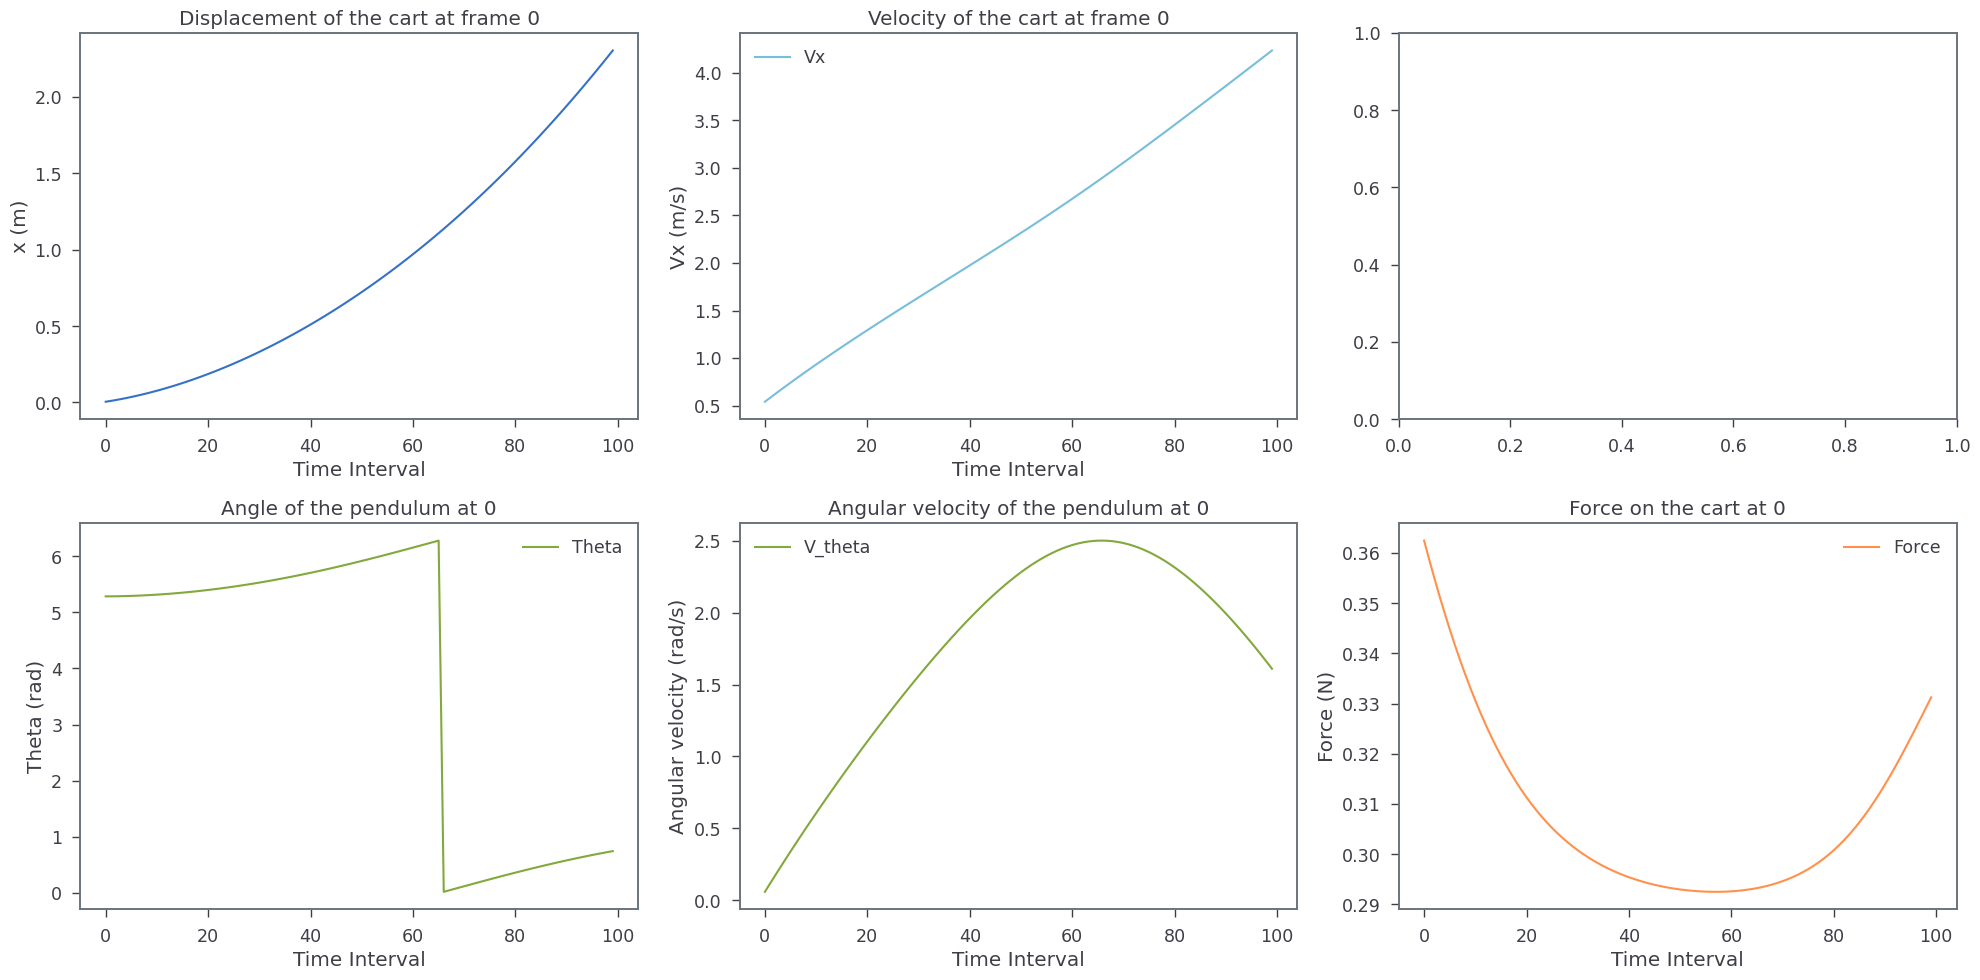

Angle: 302.7042305048303 5.2831855
Angle: 302.7373979034399 5.2837644
Angle: 302.8033775308223 5.284916
Angle: 302.9018688586538 5.286635
Angle: 303.03248939634113 5.2889147
Angle: 303.19491129480406 5.2917495
Angle: 303.3888613464757 5.2951345
Angle: 303.61398438151934 5.2990637
Angle: 303.8700071923681 5.303532
Angle: 304.15660192994187 5.308534
Angle: 304.4734953866738 5.314065
Angle: 304.82041435499707 5.32012
Angle: 305.1970856273449 5.326694
Angle: 305.6032086753939 5.333782
Angle: 306.0385376123338 5.34138
Angle: 306.50279923059793 5.349483
Angle: 306.99577496413275 5.358087
Angle: 307.5171916053715 5.3671875
Angle: 308.06677594674744 5.3767796
Angle: 308.644309422207 5.3868594
Angle: 309.2495461449402 5.397423
Angle: 309.8822402281368 5.4084654
Angle: 310.5421731057435 5.4199834
Angle: 311.22904424943664 5.4319715
Angle: 311.94266241391955 5.4444265
Angle: 312.6827817123821 5.457344
Angle: 313.4491016165009 5.470719
Angle: 314.24140356022235 5.484547
Angle: 315.0594143359798 5.

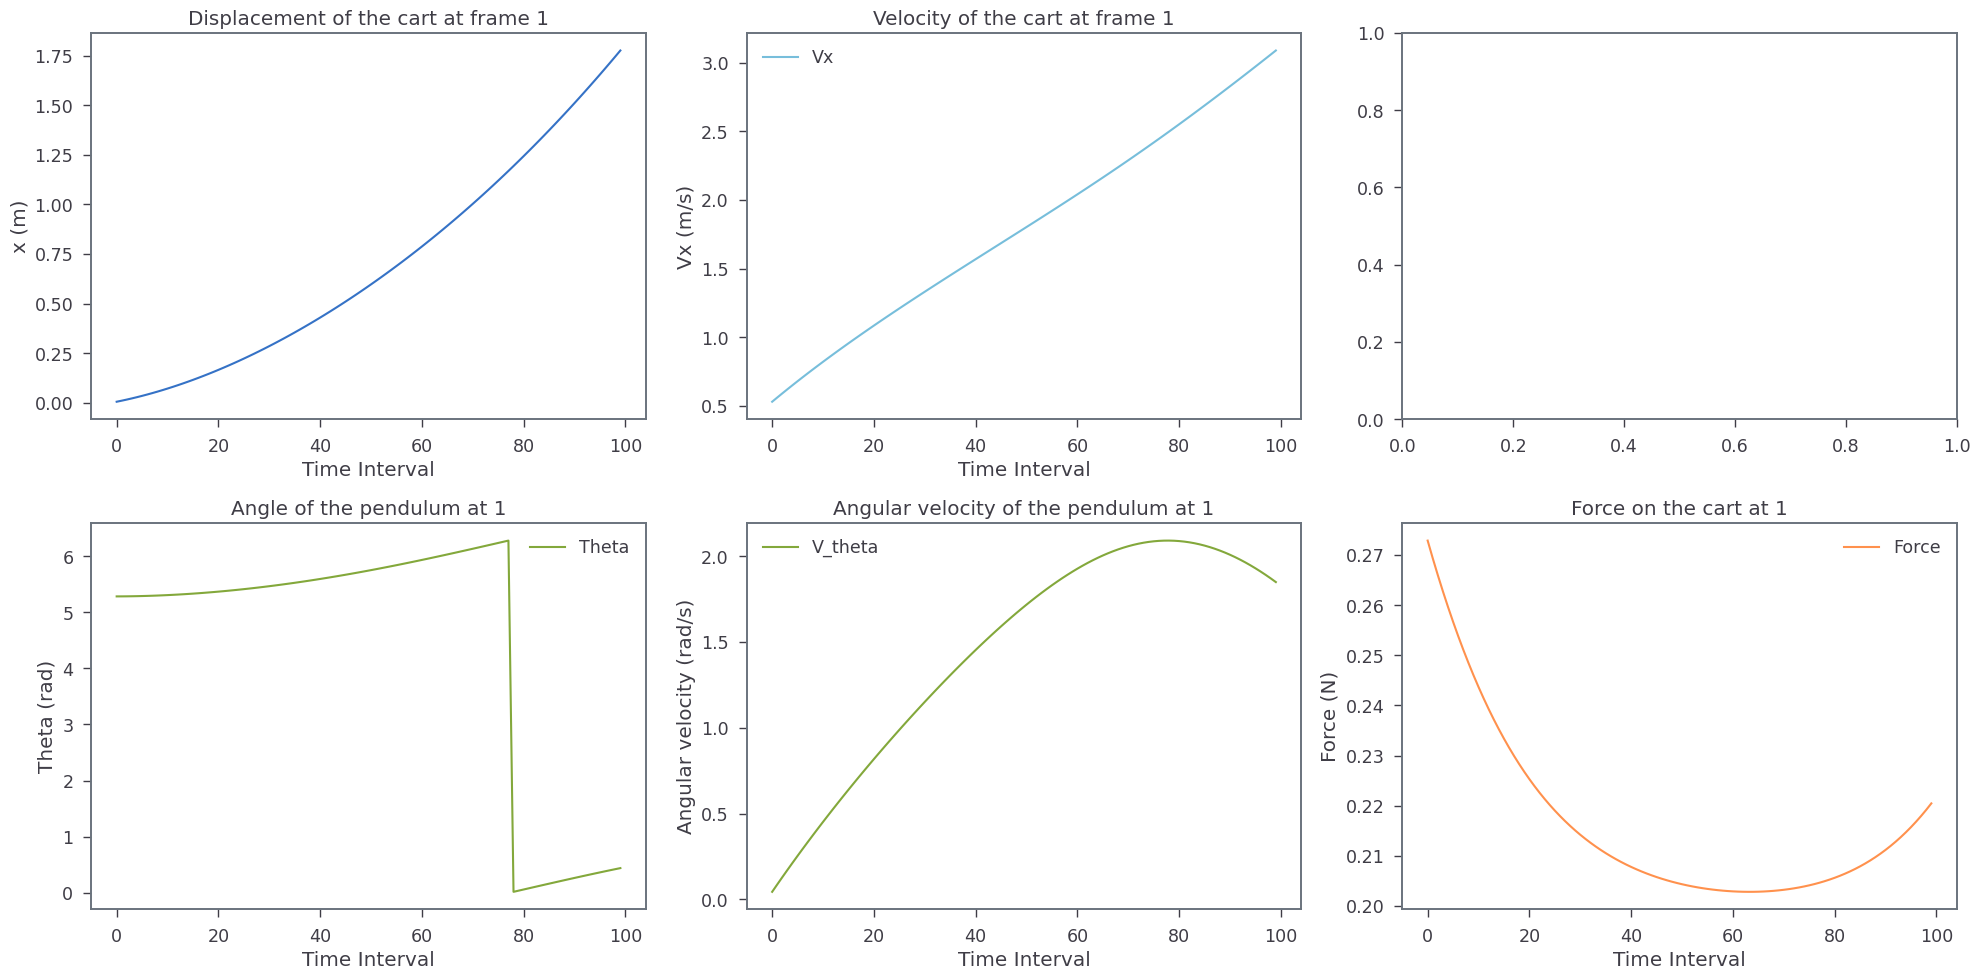

Angle: 302.7042305048303 5.2831855
Angle: 302.72920167643593 5.2836213
Angle: 302.77881617056687 5.2844872
Angle: 302.8527734588998 5.285778
Angle: 302.9507456923544 5.287488
Angle: 303.07248698412076 5.289613
Angle: 303.21766948511856 5.2921467
Angle: 303.3860473085377 5.2950854
Angle: 303.5773472468114 5.2984242
Angle: 303.7912960923729 5.3021584
Angle: 304.027647958412 5.3062835
Angle: 304.28618427887534 5.310796
Angle: 304.5666591669527 5.315691
Angle: 304.8688267358341 5.320965
Angle: 305.19246841946597 5.3266134
Angle: 305.53739297255163 5.3326335
Angle: 305.9033545082809 5.3390207
Angle: 306.29018910211374 5.3457723
Angle: 306.6976781879967 5.3528843
Angle: 307.125630520633 5.3603535
Angle: 307.57385485472594 5.3681765
Angle: 308.042132624222 5.3763494
Angle: 308.53035454609454 5.3848705
Angle: 309.0382474127767 5.393735
Angle: 309.56572926199846 5.402941
Angle: 310.11255420694965 5.412485
Angle: 310.6785583230903 5.4223638
Angle: 311.2636050066369 5.4325747
Angle: 311.867475691

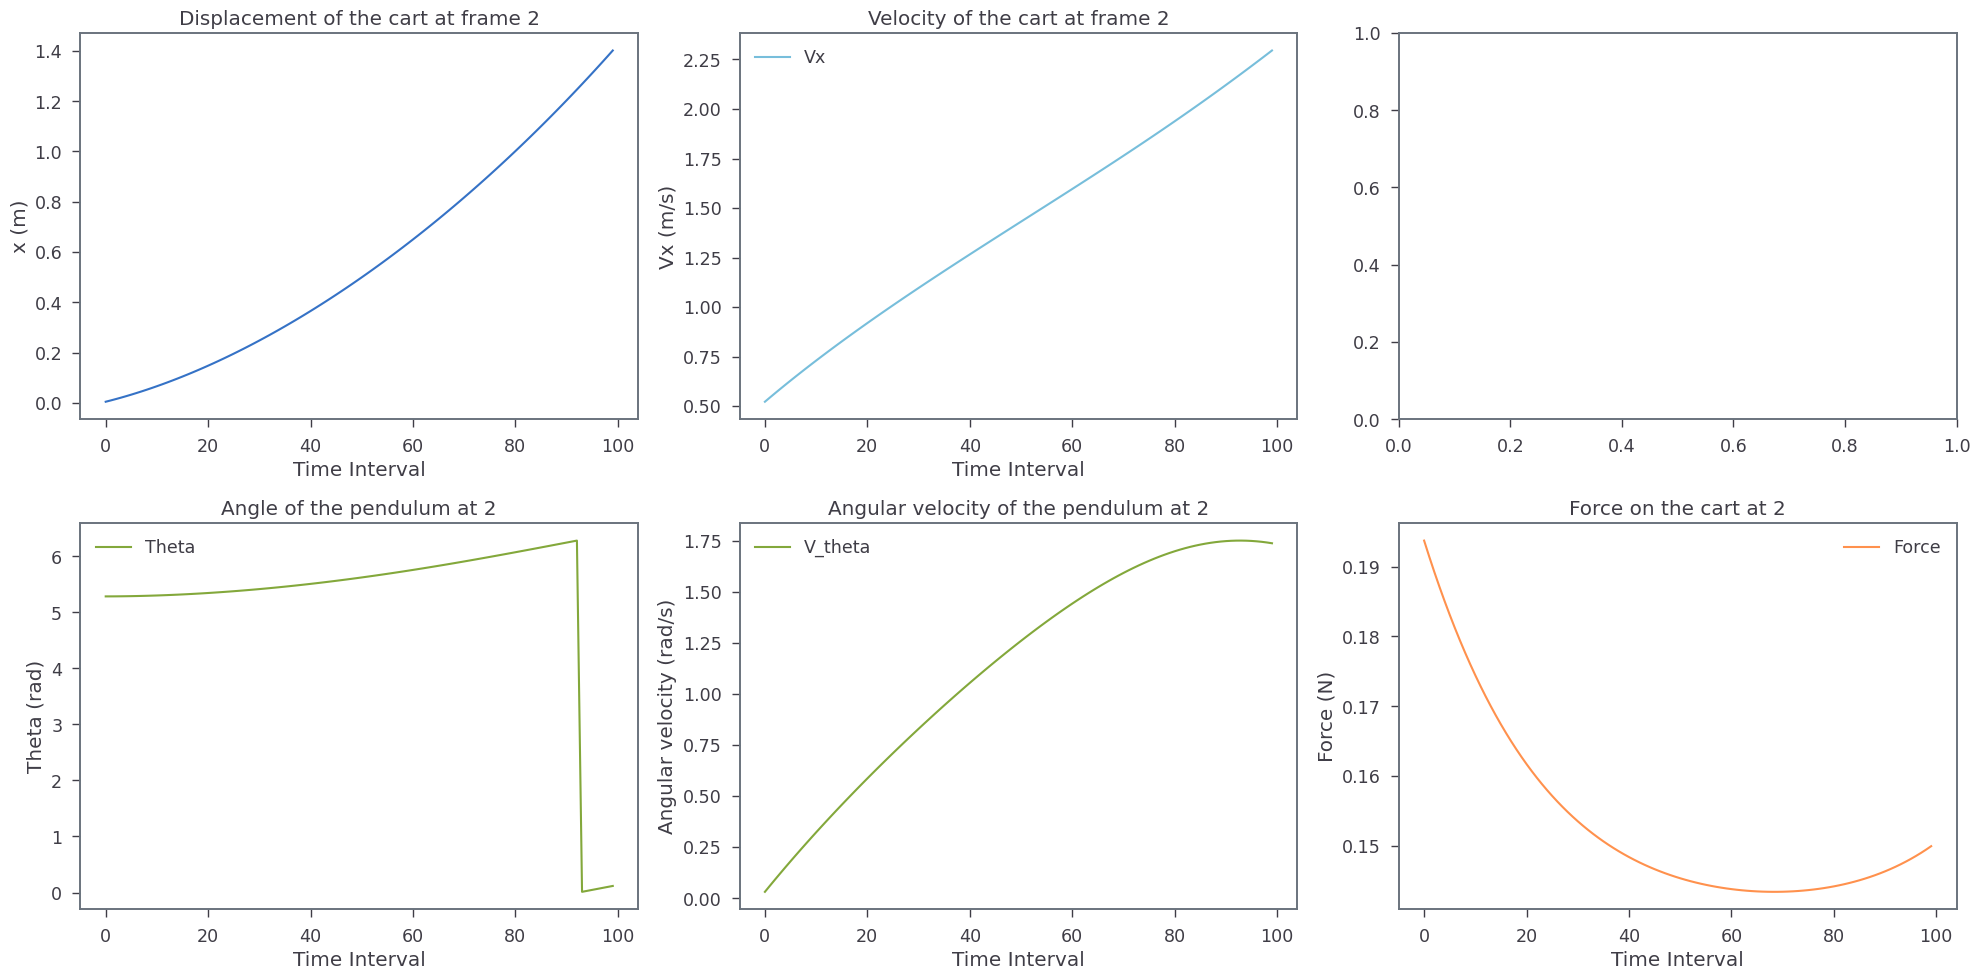

Angle: 302.7042305048303 5.2831855
Angle: 302.7219616759157 5.283495
Angle: 302.75720545203296 5.28411
Angle: 302.8097705878854 5.2850275
Angle: 302.8794385174195 5.2862434
Angle: 302.9660453160953 5.287755
Angle: 303.0693997386159 5.289559
Angle: 303.18931053968464 5.2916517
Angle: 303.32558647400475 5.29403
Angle: 303.4780909377928 5.296692
Angle: 303.6466600065087 5.299634
Angle: 303.8311024348557 5.302853
Angle: 304.03130893980716 5.3063474
Angle: 304.24708827606617 5.3101134
Angle: 304.47830383984945 5.314149
Angle: 304.72484634813026 5.318452
Angle: 304.9865518763684 5.3230195
Angle: 305.26328382078066 5.3278494
Angle: 305.55490557758355 5.332939
Angle: 305.8613078637503 5.338287
Angle: 306.1823813962543 5.3438907
Angle: 306.51796225055534 5.3497477
Angle: 306.86796846438347 5.3558564
Angle: 307.23226343395527 5.3622146
Angle: 307.610737876244 5.36882
Angle: 308.003282508223 5.3756714
Angle: 308.40978804686546 5.3827662
Angle: 308.83014520914475 5.390103
Angle: 309.2642447120341 

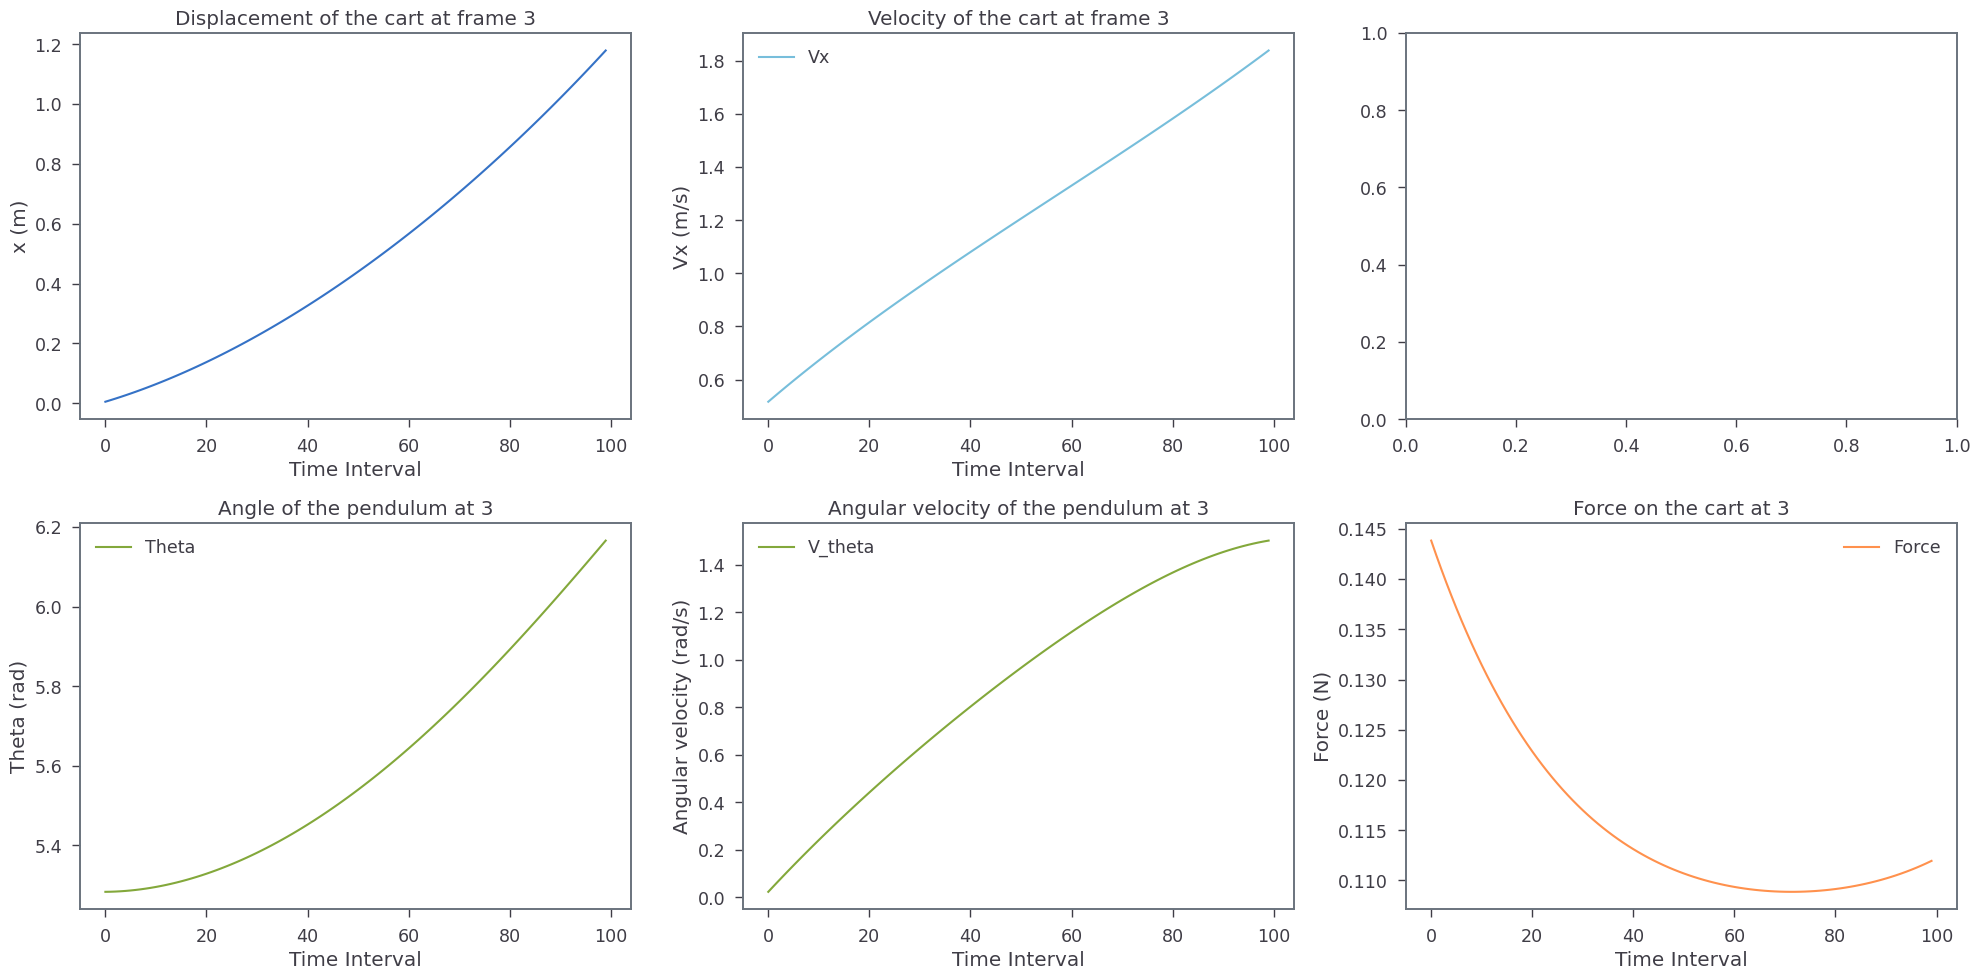

Angle: 302.7042305048303 5.2831855
Angle: 302.7173991095501 5.2834153
Angle: 302.74357239444964 5.283872
Angle: 302.78266839725876 5.2845545
Angle: 302.8345231934375 5.2854595
Angle: 302.8990548207158 5.286586
Angle: 302.9760993545535 5.2879305
Angle: 303.0656021534374 5.2894926
Angle: 303.16737197207055 5.291269
Angle: 303.28135416893974 5.293258
Angle: 303.40743946101816 5.295459
Angle: 303.54551856527917 5.2978687
Angle: 303.69548219869597 5.300486
Angle: 303.8572210782419 5.303309
Angle: 304.0306805624035 5.3063364
Angle: 304.21575136815414 5.3095665
Angle: 304.41229689171047 5.312997
Angle: 304.6203171330724 5.3166275
Angle: 304.8396481676998 5.3204556
Angle: 305.07023535407944 5.32448
Angle: 305.3119967299412 5.3286996
Angle: 305.5648503330151 5.3331127
Angle: 305.828714201031 5.337718
Angle: 306.103506371719 5.342514
Angle: 306.3891722035656 5.3475
Angle: 306.6856297343008 5.352674
Angle: 306.99279700165465 5.358035
Angle: 307.31059204335696 5.3635817
Angle: 307.6389602178945 5.

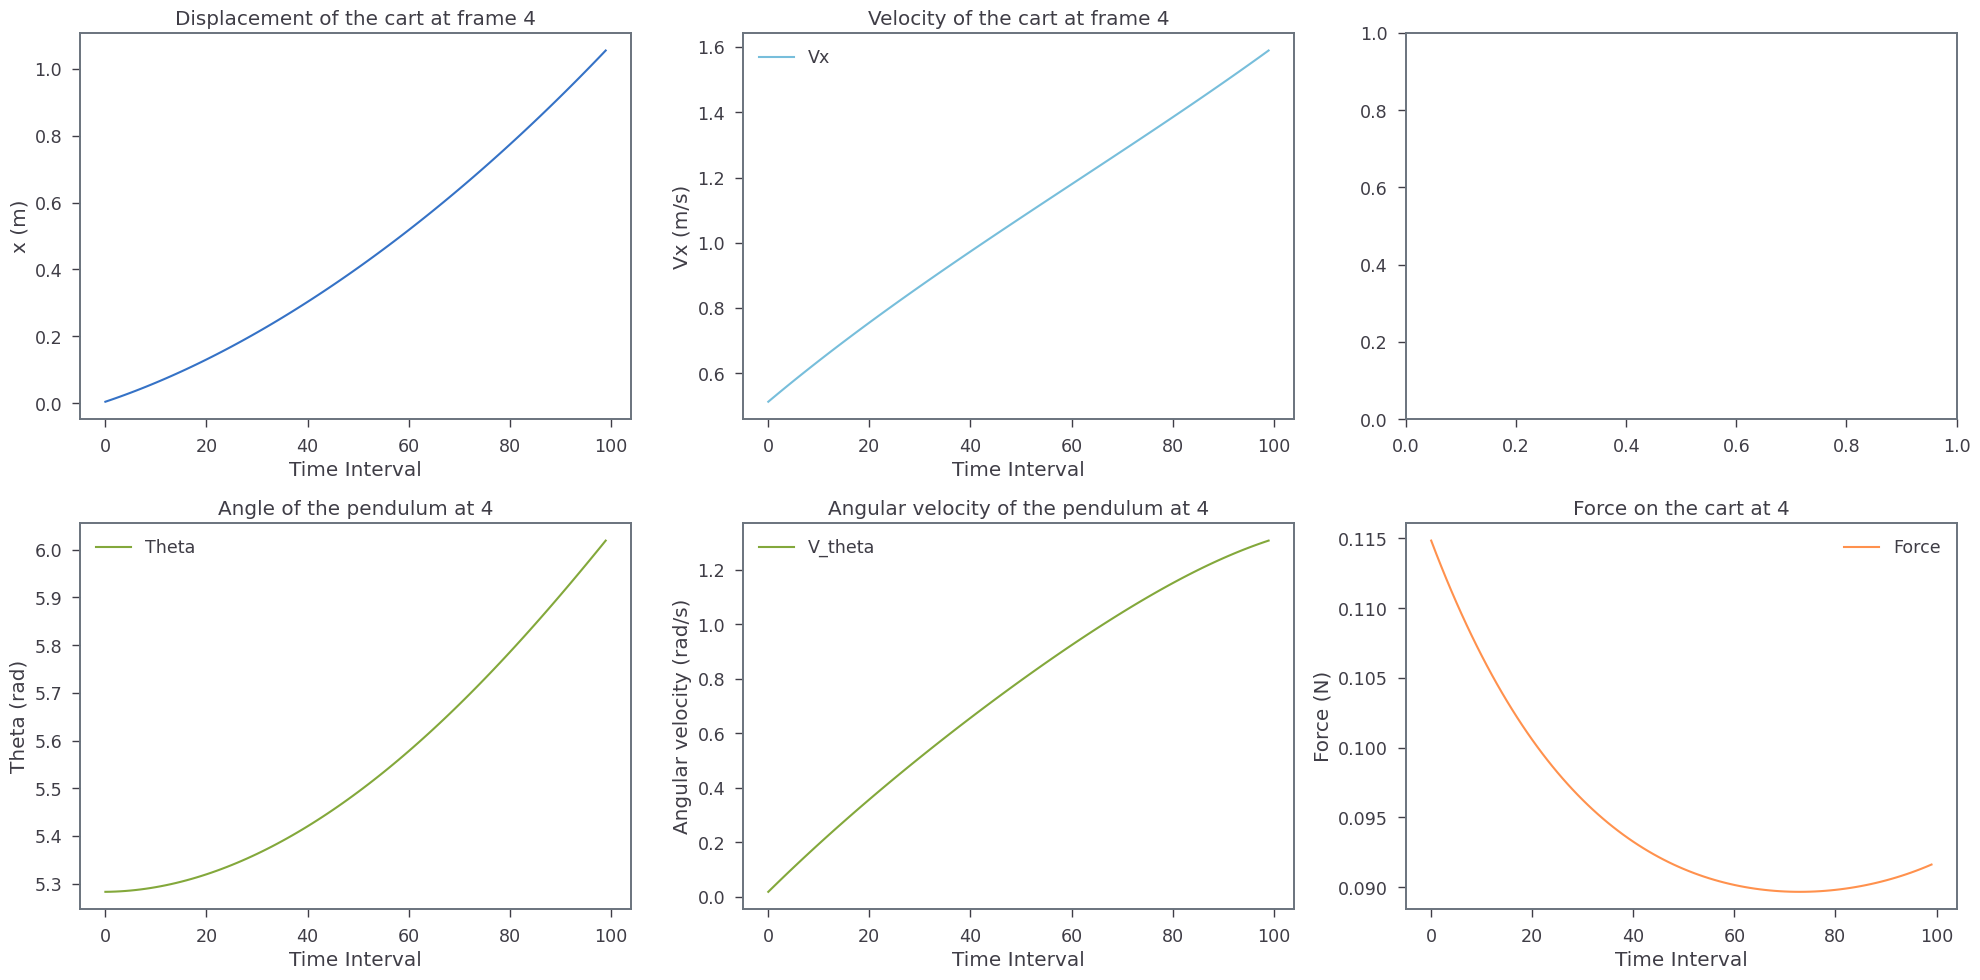

Angle: 302.7042305048303 5.2831855
Angle: 302.71474899615214 5.283369
Angle: 302.7356766957691 5.2837343
Angle: 302.7669316414111 5.28428
Angle: 302.80845919156474 5.2850046
Angle: 302.8601500632034 5.285907
Angle: 302.9219496148137 5.2869854
Angle: 302.9937758841255 5.288239
Angle: 303.07554690886894 5.289666
Angle: 303.16718072677384 5.2912655
Angle: 303.2686226963268 5.293036
Angle: 303.37979085525797 5.294976
Angle: 303.50060324129714 5.297085
Angle: 303.6310325336877 5.299361
Angle: 303.7709694494029 5.3018036
Angle: 303.92038666768616 5.3044114
Angle: 304.0792022262673 5.3071833
Angle: 304.2473341628763 5.3101177
Angle: 304.42475515675653 5.3132143
Angle: 304.6114105663947 5.316472
Angle: 304.8072184295206 5.3198895
Angle: 305.01212410462097 5.323466
Angle: 305.2261002709391 5.3272004
Angle: 305.44903764544836 5.3310914
Angle: 305.6809362281486 5.335139
Angle: 305.92171405676993 5.339341
Angle: 306.17131648979887 5.3436975
Angle: 306.42971620647876 5.3482075
Angle: 306.6968585652

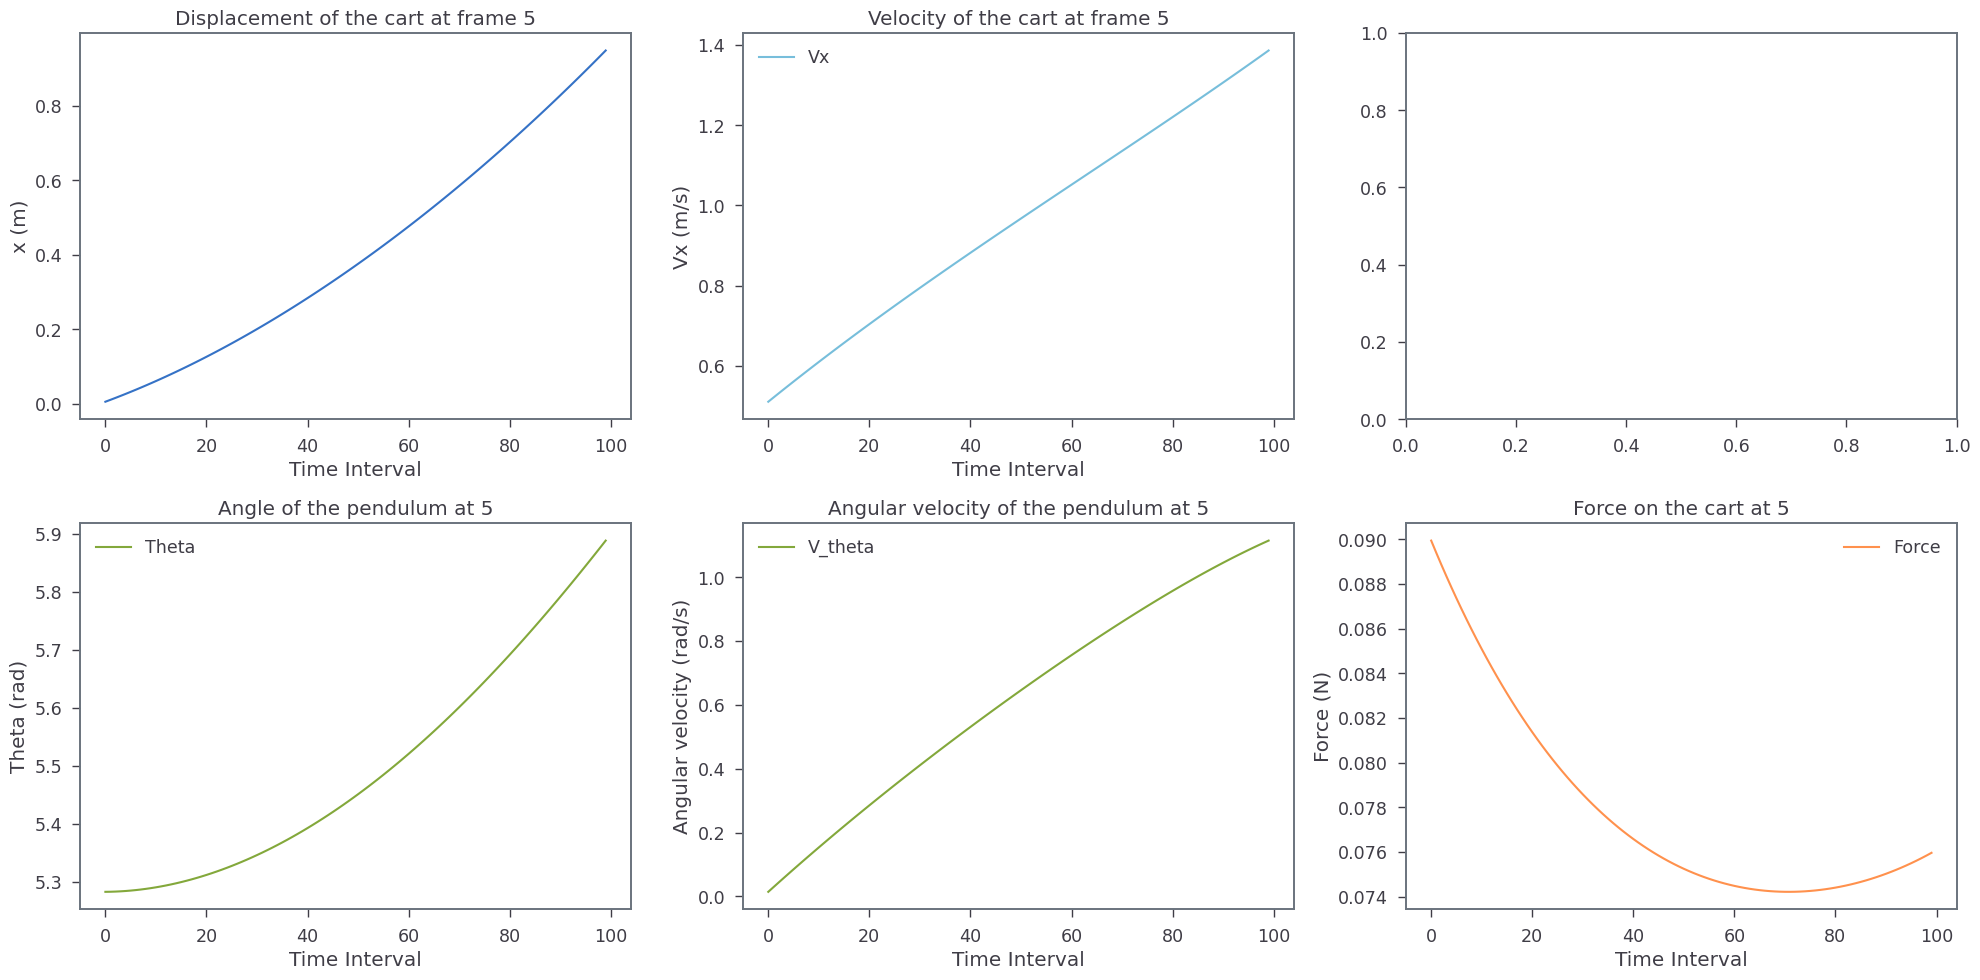

Angle: 302.7042305048303 5.2831855
Angle: 302.71245405259106 5.283329
Angle: 302.72887382735576 5.2836156
Angle: 302.75340786685445 5.284044
Angle: 302.7860288503304 5.284613
Angle: 302.826709457027 5.285323
Angle: 302.8753404039175 5.286172
Angle: 302.93194901175855 5.28716
Angle: 302.9964259975235 5.2882853
Angle: 303.06877136121227 5.289548
Angle: 303.1489304613115 5.290947
Angle: 303.23687597706464 5.292482
Angle: 303.3325259462015 5.2941513
Angle: 303.4358803687221 5.295955
Angle: 303.5468572823565 5.297892
Angle: 303.66545668710455 5.299962
Angle: 303.79162394145305 5.302164
Angle: 303.9253317246452 5.3044977
Angle: 304.06652539516773 5.306962
Angle: 304.2151776322639 5.3095565
Angle: 304.37123379442033 5.31228
Angle: 304.5346665608804 5.3151326
Angle: 304.70547593164406 5.318114
Angle: 304.88357994444135 5.3212223
Angle: 305.0689512785155 5.3244576
Angle: 305.2615899338665 5.32782
Angle: 305.4614139482244 5.3313074
Angle: 305.66842332158916 5.3349204
Angle: 305.8825907332041 5.3

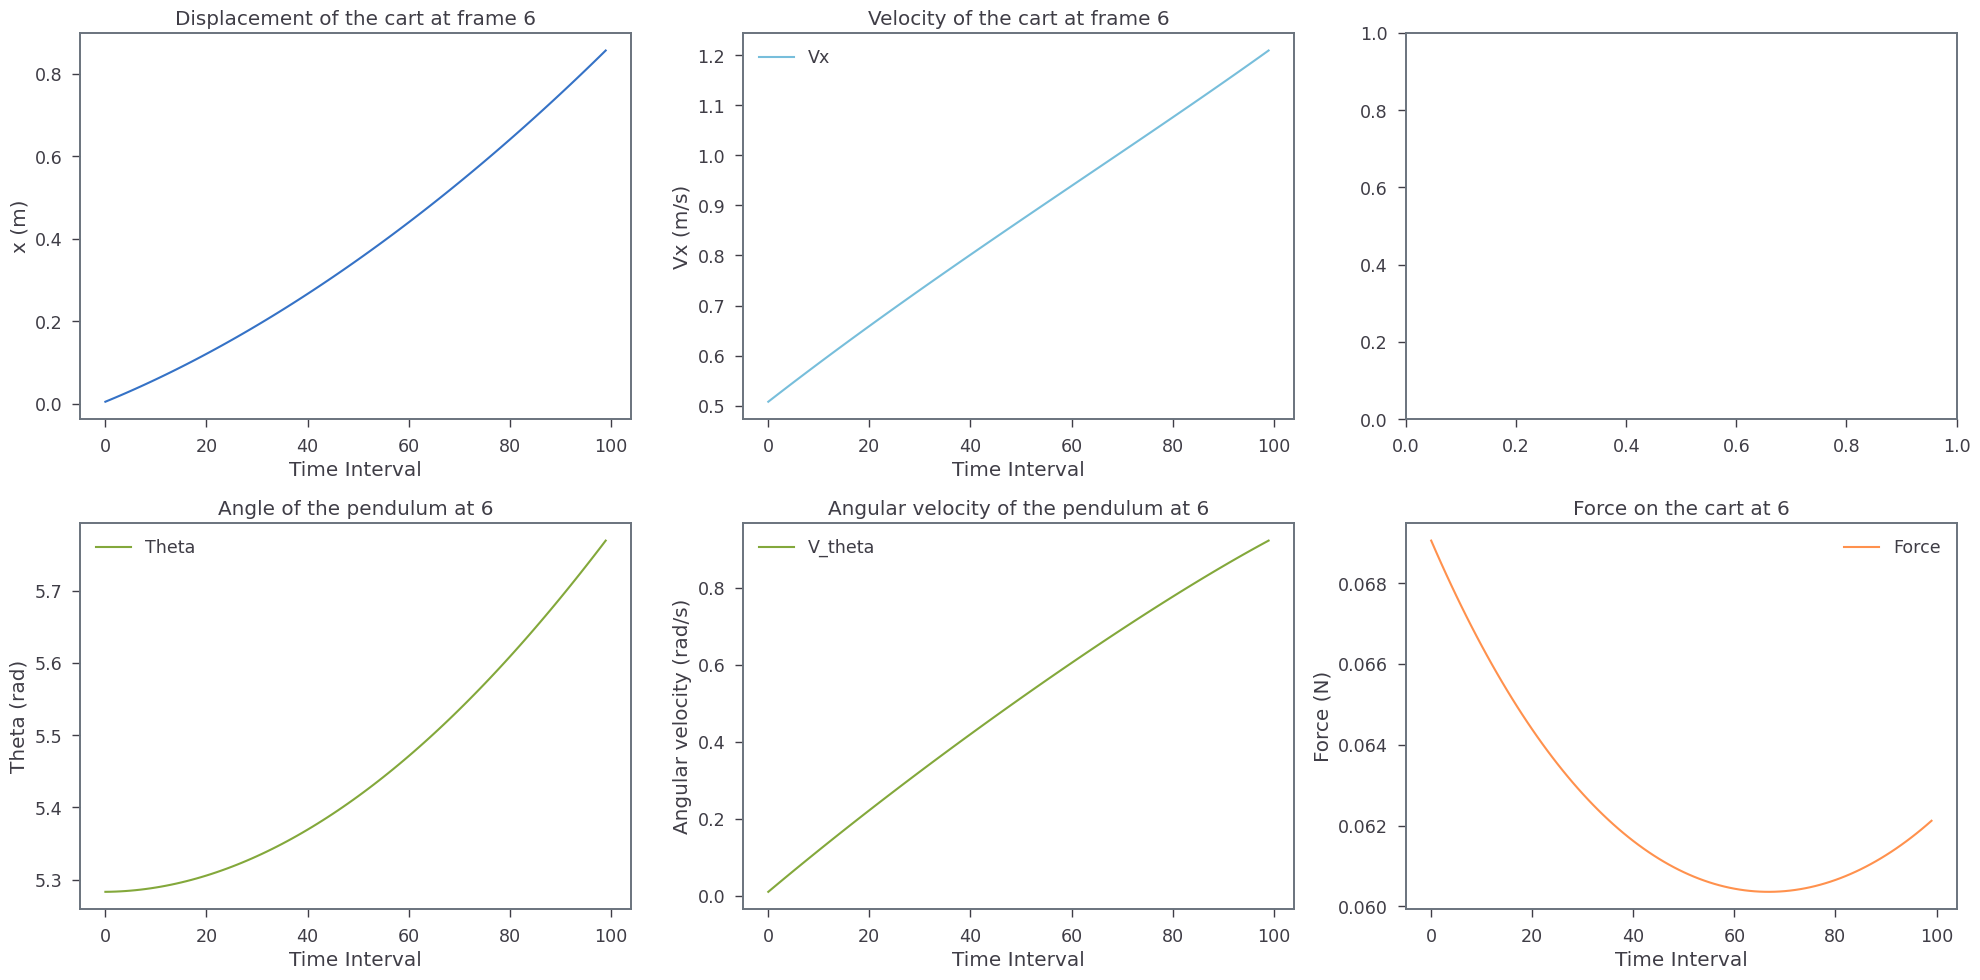

Angle: 302.7042305048303 5.2831855
Angle: 302.7105415996234 5.2832956
Angle: 302.7231637892096 5.283516
Angle: 302.74204243207555 5.2838454
Angle: 302.7671502074645 5.2842836
Angle: 302.79848711537653 5.2848306
Angle: 302.8360258350549 5.2854857
Angle: 302.8797117249863 5.286248
Angle: 302.9295447851707 5.287118
Angle: 302.98549769485146 5.2880945
Angle: 303.0475704540286 5.289178
Angle: 303.1156811004319 5.2903666
Angle: 303.18985695481825 5.2916613
Angle: 303.2700433756742 5.293061
Angle: 303.35624036299976 5.294565
Angle: 303.44842059603826 5.296174
Angle: 303.546556754033 5.297887
Angle: 303.6506215162273 5.299703
Angle: 303.7606148826212 5.301623
Angle: 303.8764822117013 5.303645
Angle: 303.9982508242243 5.3057704
Angle: 304.1258660786768 5.3079977
Angle: 304.2593006543022 5.3103266
Angle: 304.3985545511004 5.312757
Angle: 304.5436004483148 5.3152885
Angle: 304.6944110251887 5.3179207
Angle: 304.85098628172204 5.3206534
Angle: 305.0132988971582 5.3234863
Angle: 305.18129422998385 

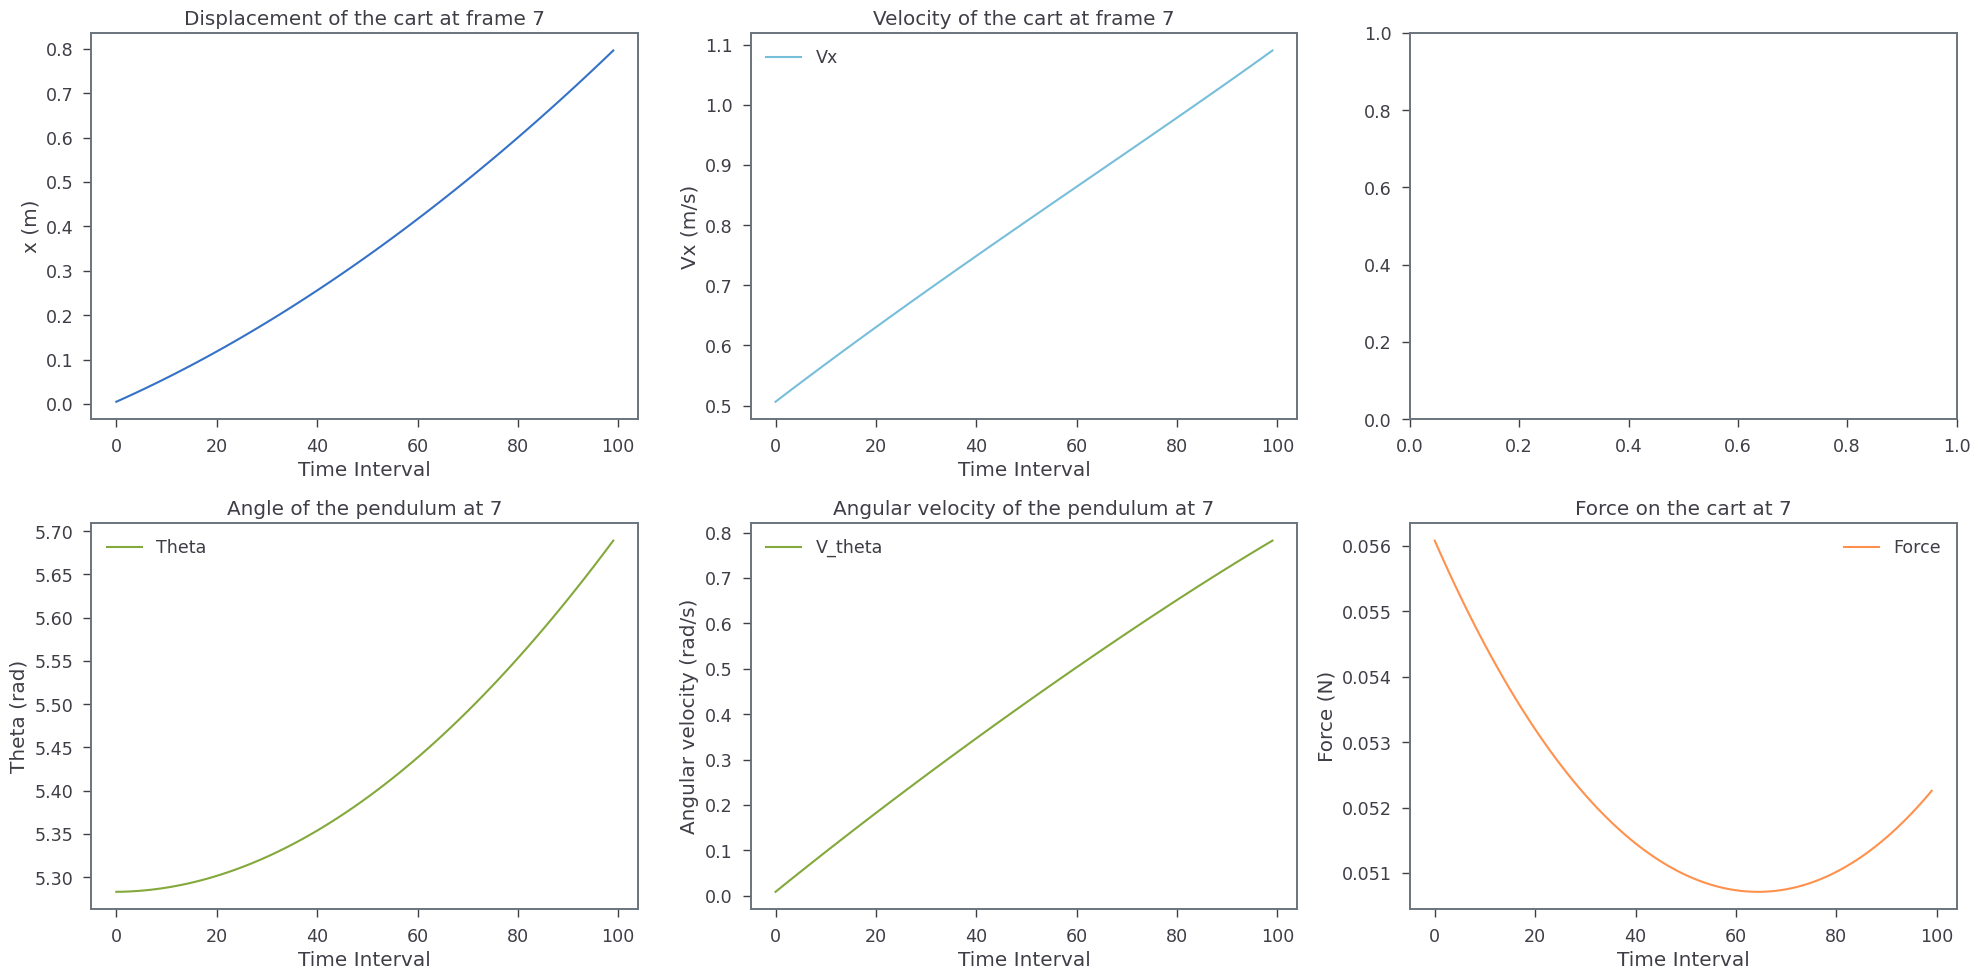

Angle: 302.7042305048303 5.2831855
Angle: 302.7093668070862 5.283275
Angle: 302.7196120908412 5.283454
Angle: 302.7349663560954 5.283722
Angle: 302.75540228209206 5.2840786
Angle: 302.7808925480746 5.2845235
Angle: 302.8114371540429 5.2850566
Angle: 302.84703609999696 5.285678
Angle: 302.8876620651802 5.286387
Angle: 302.93328772883586 5.2871833
Angle: 302.98391309096405 5.288067
Angle: 303.03951083080796 5.289037
Angle: 303.1000536276109 5.290094
Angle: 303.1655688021297 5.2912374
Angle: 303.23602903360756 5.292467
Angle: 303.3114070012878 5.2937827
Angle: 303.3917027051705 5.295184
Angle: 303.4768615037422 5.2966704
Angle: 303.5669380385163 5.2982426
Angle: 303.6618503472228 5.299899
Angle: 303.76165307137506 5.301641
Angle: 303.866264248703 5.303467
Angle: 303.9757385207199 5.3053775
Angle: 304.09002124591257 5.307372
Angle: 304.2090851035242 5.30945
Angle: 304.3329574143116 5.311612
Angle: 304.4615835367613 5.313857
Angle: 304.59501811238664 5.316186
Angle: 304.73315185816097 5.318

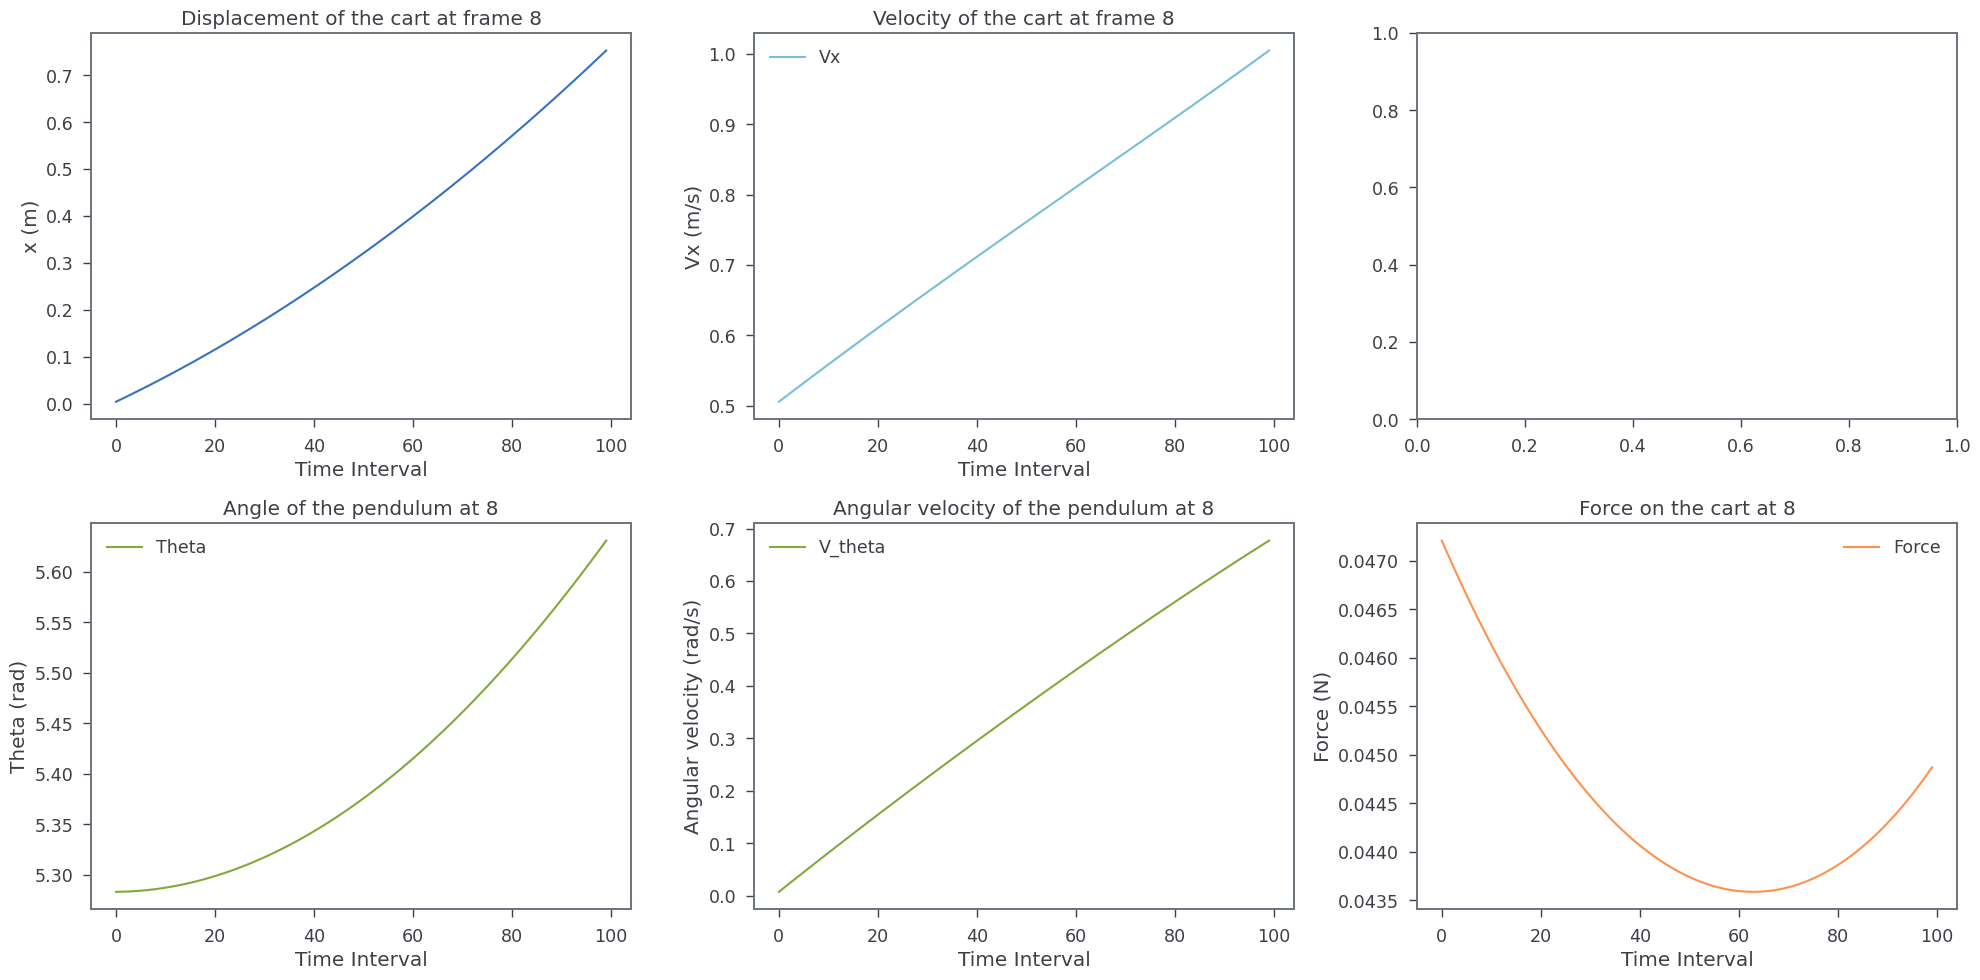

Angle: 302.7042305048303 5.2831855
Angle: 302.7085471843858 5.283261
Angle: 302.7171805434967 5.2834115
Angle: 302.7301032614063 5.283637
Angle: 302.7473153381148 5.2839375
Angle: 302.768816773622 5.2843127
Angle: 302.79458024717127 5.2847624
Angle: 302.82460575876263 5.2852864
Angle: 302.85886598763943 5.2858844
Angle: 302.8973609338016 5.2865562
Angle: 302.94009059724925 5.287302
Angle: 302.98702765722555 5.288121
Angle: 303.0381994344873 5.2890143
Angle: 303.09355128752105 5.2899804
Angle: 303.1530832163269 5.2910194
Angle: 303.21679522090477 5.2921314
Angle: 303.28468730125473 5.2933164
Angle: 303.35673213662 5.294574
Angle: 303.43292972700067 5.2959037
Angle: 303.5132800723967 5.297306
Angle: 303.5977558520514 5.2987804
Angle: 303.6863297452081 5.3003263
Angle: 303.77905639338024 5.3019447
Angle: 303.87585383429763 5.303634
Angle: 303.97677670947377 5.3053956
Angle: 304.0817703773952 5.307228
Angle: 304.19083483806196 5.3091316
Angle: 304.30397009147407 5.311106
Angle: 304.4211761

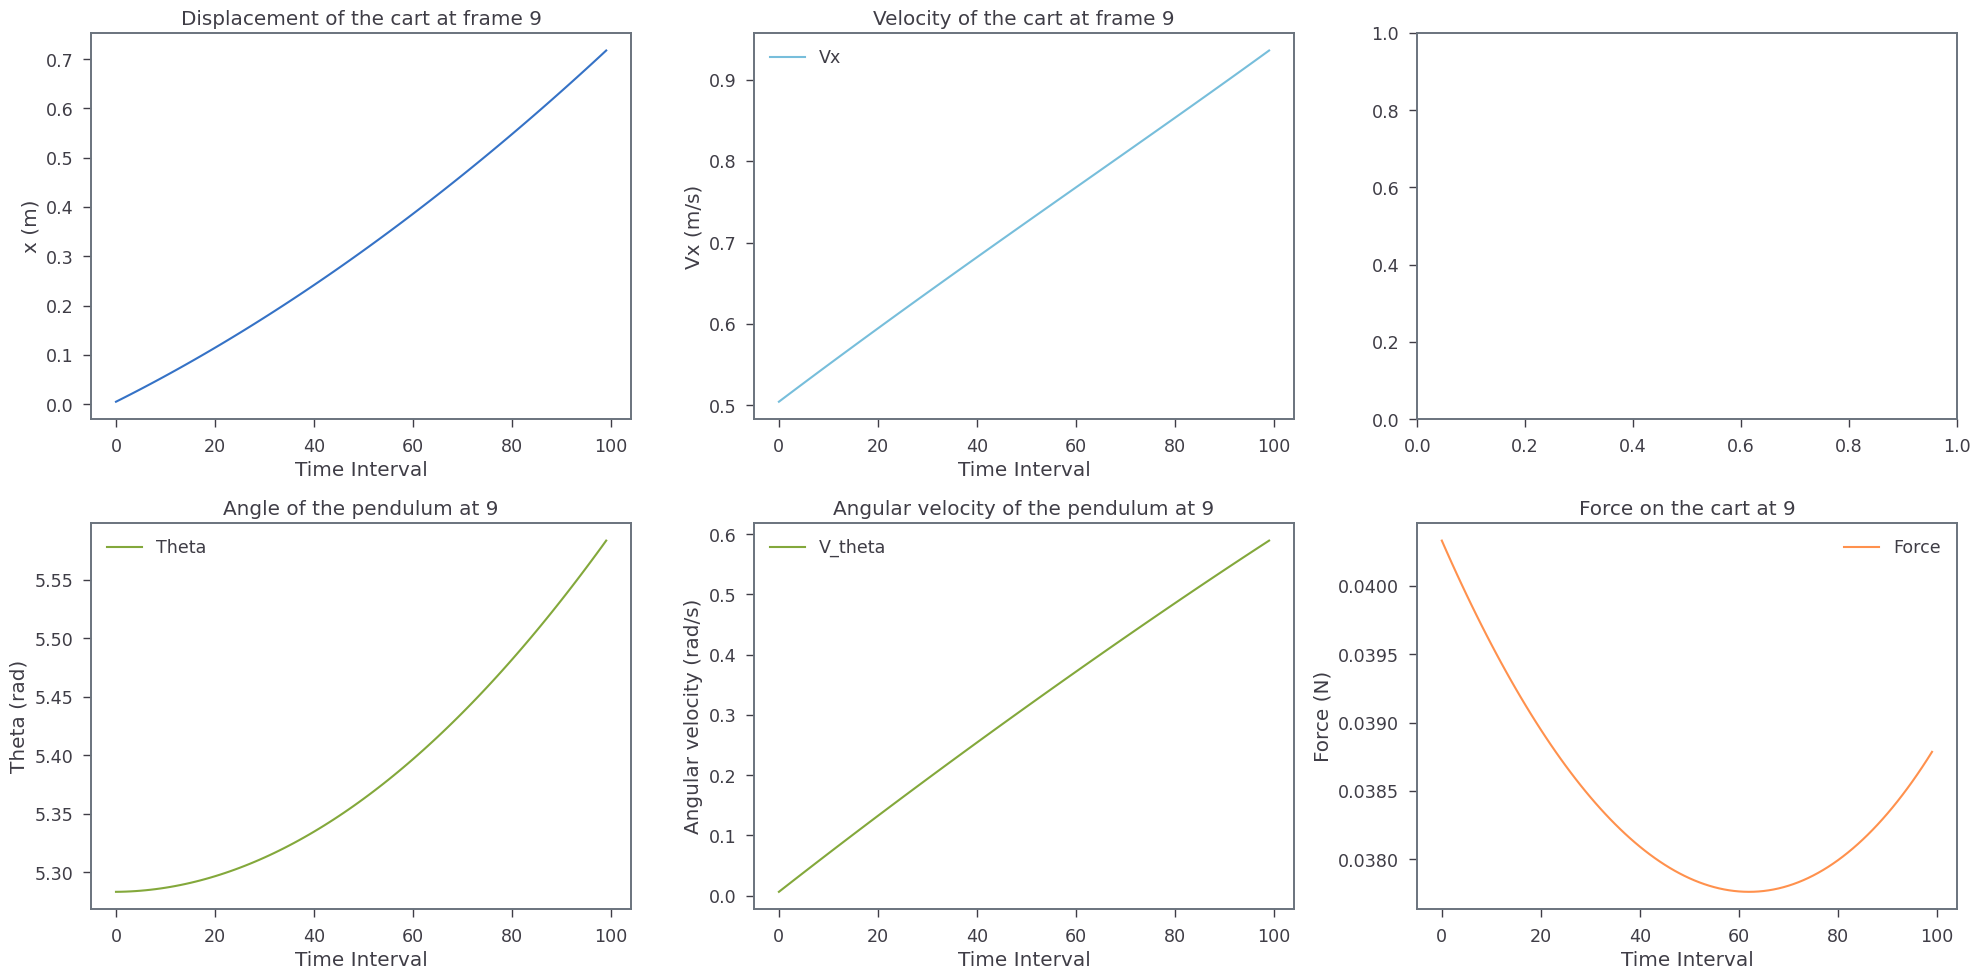

Angle: 302.7042305048303 5.2831855
Angle: 302.70791880698215 5.28325
Angle: 302.71529541128575 5.2833786
Angle: 302.7263329969845 5.2835712
Angle: 302.74105888483507 5.2838283
Angle: 302.75944575408073 5.284149
Angle: 302.78146628396485 5.2845335
Angle: 302.8071477952441 5.2849817
Angle: 302.83646296716176 5.2854934
Angle: 302.8694117997179 5.2860684
Angle: 302.9059942929125 5.286707
Angle: 302.94618312598885 5.2874084
Angle: 302.989978298947 5.2881727
Angle: 303.0373798117869 5.289
Angle: 303.08838766450856 5.2898903
Angle: 303.14297453635527 5.290843
Angle: 303.2011677480838 5.2918587
Angle: 303.2629126581807 5.2929363
Angle: 303.3282365874027 5.2940764
Angle: 303.3971122149931 5.2952785
Angle: 303.4695668617086 5.296543
Angle: 303.54557320679254 5.2978697
Angle: 303.62510392948815 5.2992578
Angle: 303.7081863505522 5.300708
Angle: 303.7947931492279 5.3022194
Angle: 303.8848970047587 5.303792
Angle: 303.97855255865795 5.3054266
Angle: 304.07570516941223 5.307122
Angle: 304.1763821577

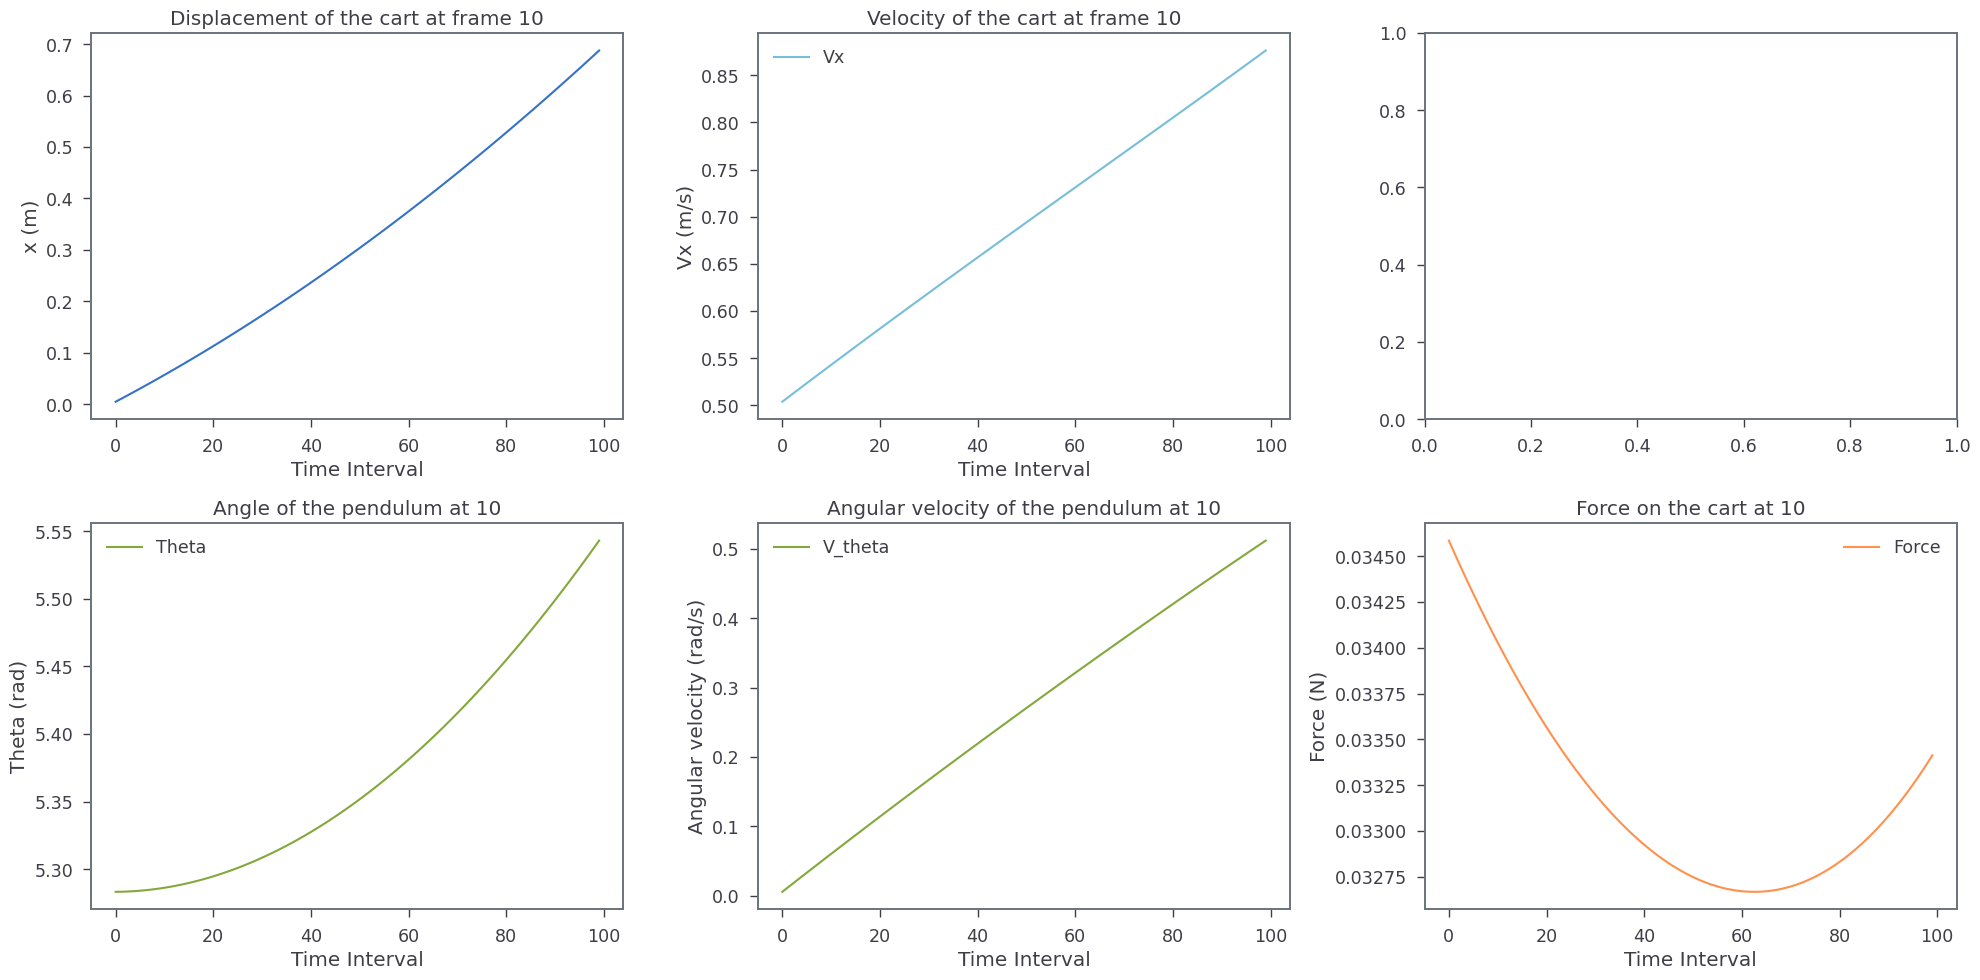

Angle: 302.7042305048303 5.2831855
Angle: 302.70739971260525 5.283241
Angle: 302.71371080739834 5.283351
Angle: 302.7231911099663 5.2835164
Angle: 302.7358132995525 5.2837367
Angle: 302.7515773761569 5.284012
Angle: 302.77048333977945 5.284342
Angle: 302.7925311904203 5.2847266
Angle: 302.8176936073226 5.285166
Angle: 302.8459979112431 5.28566
Angle: 302.8773894606685 5.2862077
Angle: 302.9118955763554 5.28681
Angle: 302.9495435790605 5.287467
Angle: 302.9902515065138 5.2881775
Angle: 303.0340740002286 5.2889423
Angle: 303.08098373944824 5.289761
Angle: 303.13098072417273 5.2906337
Angle: 303.18406495440206 5.29156
Angle: 303.2402091093796 5.29254
Angle: 303.29944050986194 5.293574
Angle: 303.3617318350924 5.294661
Angle: 303.42708308507116 5.2958016
Angle: 303.49549425979797 5.2969956
Angle: 303.5669380385163 5.2982426
Angle: 303.6414417419828 5.299543
Angle: 303.71900537019746 5.3008966
Angle: 303.7995742816469 5.302303
Angle: 303.8832031178446 5.3037624
Angle: 303.96983723727703 5.3

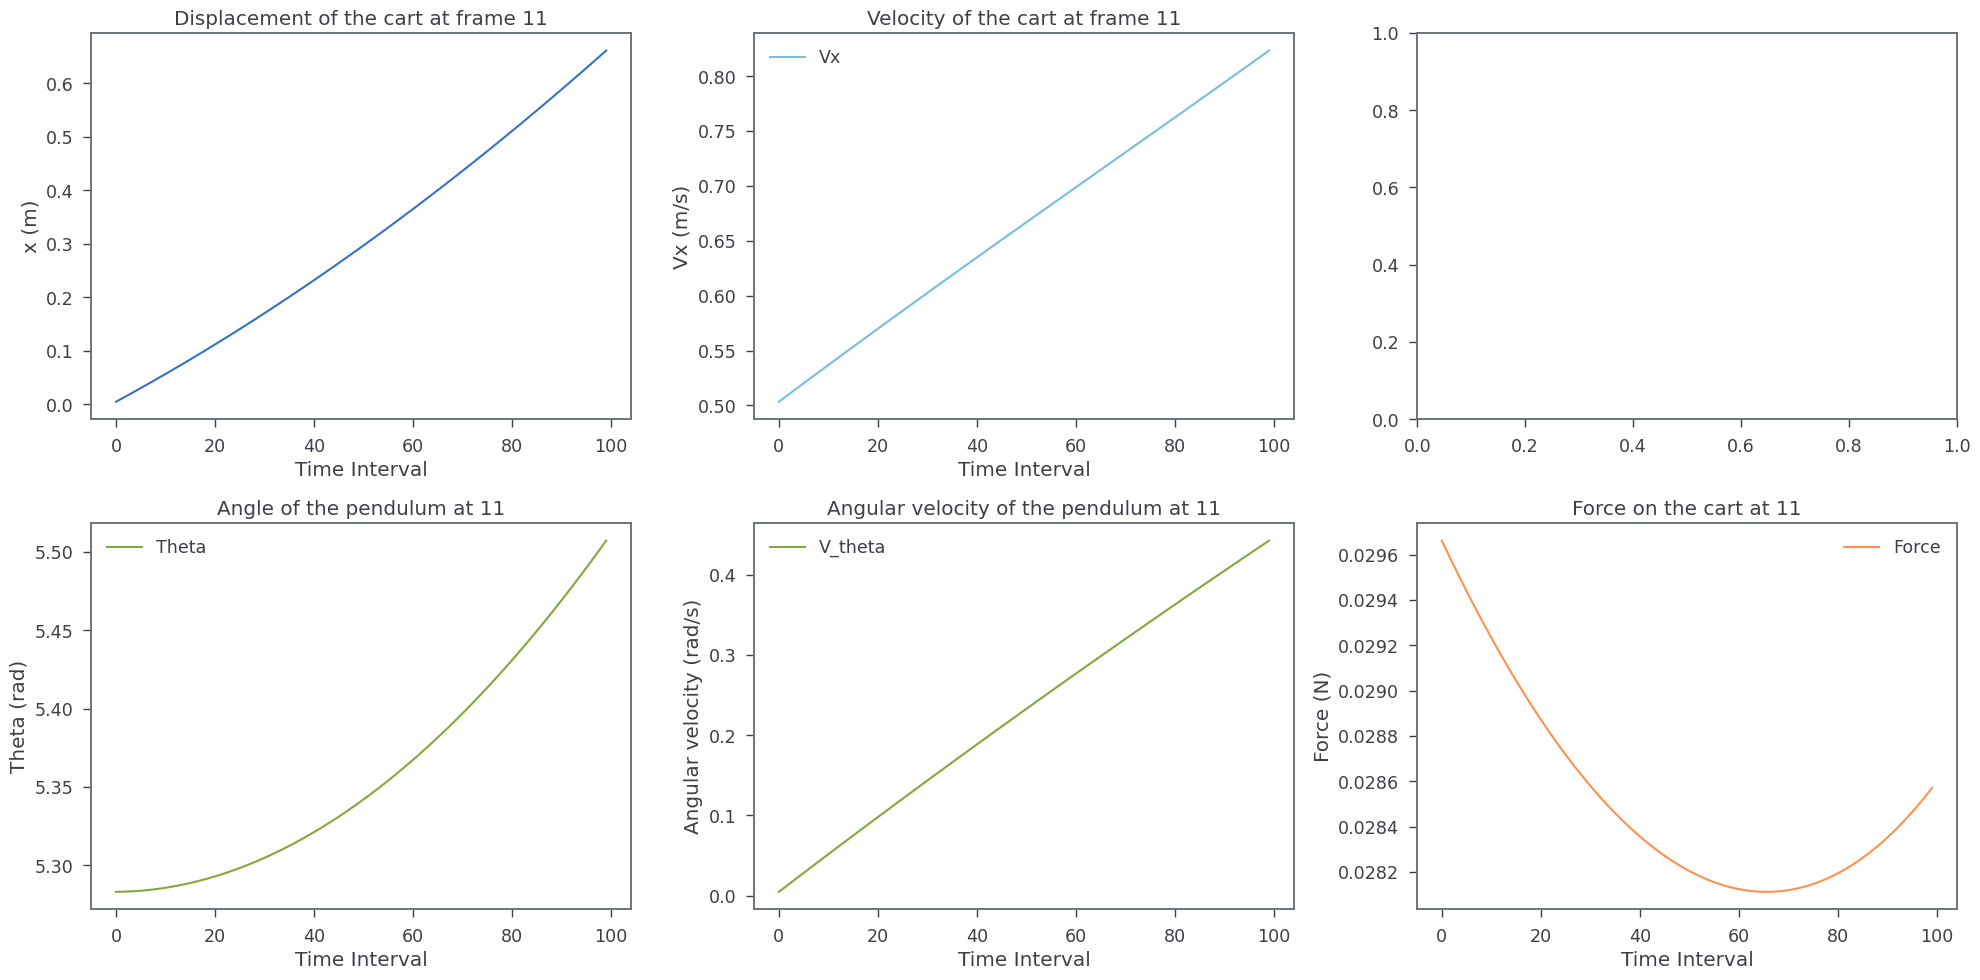

Angle: 302.7042305048303 5.2831855
Angle: 302.70693525974167 5.2832327
Angle: 302.712372090321 5.2833276
Angle: 302.72048635505496 5.283469
Angle: 302.73133269545696 5.2836585
Angle: 302.7448564700136 5.2838945
Angle: 302.7610849994815 5.284178
Angle: 302.7799909631041 5.2845078
Angle: 302.80160168163803 5.284885
Angle: 302.8258625135699 5.2853084
Angle: 302.85282810041315 5.285779
Angle: 302.8824438006543 5.286296
Angle: 302.91473693505014 5.2868595
Angle: 302.9497075036006 5.28747
Angle: 302.987328185549 5.2881265
Angle: 303.0276263016521 5.28883
Angle: 303.07054721039646 5.289579
Angle: 303.1161455532955 5.2903748
Angle: 303.16436668883574 5.2912164
Angle: 303.215237937774 5.2921042
Angle: 303.2687593001102 5.2930384
Angle: 303.32490345508774 5.2940183
Angle: 303.3836704027065 5.295044
Angle: 303.44508746372327 5.296116
Angle: 303.5090999966246 5.297233
Angle: 303.5757353221673 5.298396
Angle: 303.6450207611079 5.2996054
Angle: 303.71687435117644 5.3008595
Angle: 303.79137805464296 

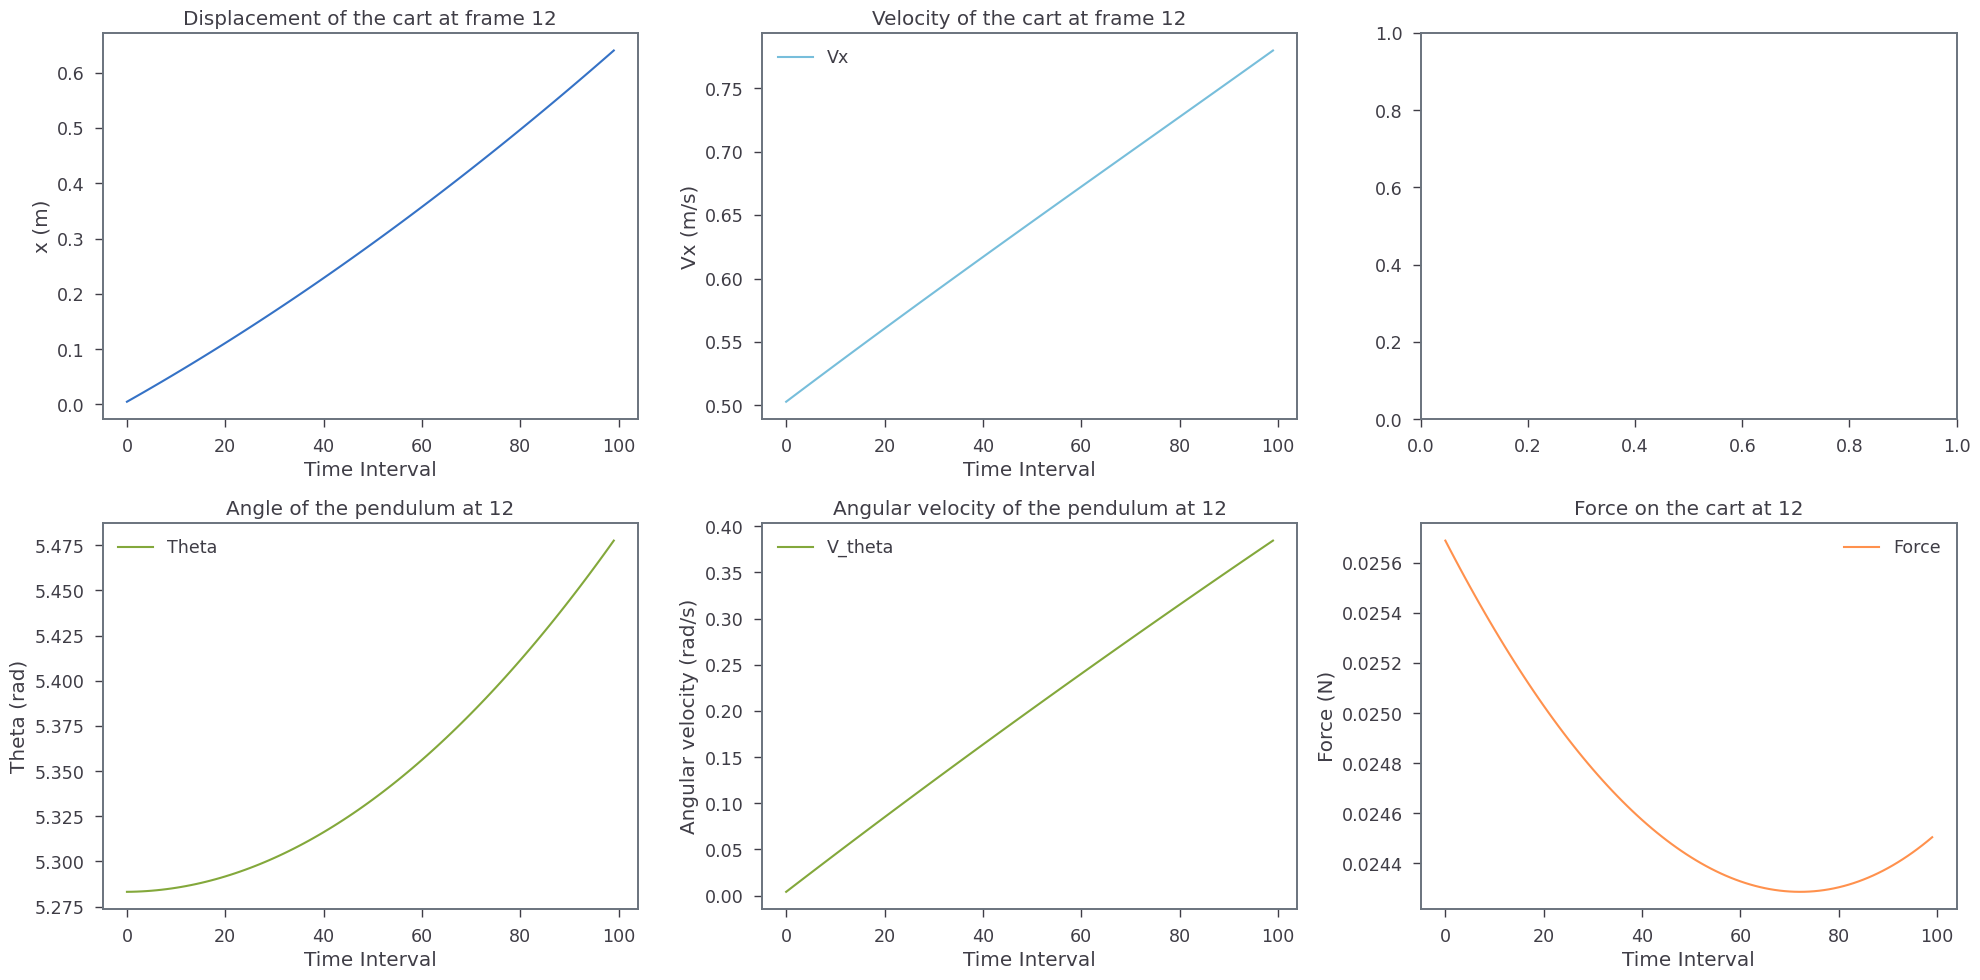

Angle: 302.7042305048303 5.2831855
Angle: 302.70658008990483 5.2832265
Angle: 302.7112792600538 5.2833085
Angle: 302.7183280152772 5.2834315
Angle: 302.7276990348185 5.283595
Angle: 302.73941963943423 5.2837996
Angle: 302.7534625083678 5.2840447
Angle: 302.7698549623758 5.284331
Angle: 302.78856968070164 5.2846575
Angle: 302.8096066633453 5.2850246
Angle: 302.83293858955005 5.285432
Angle: 302.8586201008293 5.28588
Angle: 302.8865965556697 5.2863684
Angle: 302.9168952748279 5.286897
Angle: 302.9494889375472 5.287466
Angle: 302.9844048645843 5.2880754
Angle: 303.0215884144258 5.2887244
Angle: 303.06109422858515 5.289414
Angle: 303.10289498630567 5.2901435
Angle: 303.1469906875873 5.290913
Angle: 303.1933540116733 5.2917223
Angle: 303.2420122793205 5.2925715
Angle: 303.2929654905288 5.293461
Angle: 303.3461863245415 5.2943897
Angle: 303.4016747813587 5.295358
Angle: 303.4594308609803 5.296366
Angle: 303.51948188416304 5.2974143
Angle: 303.5817732093936 5.2985015
Angle: 303.64633215742856

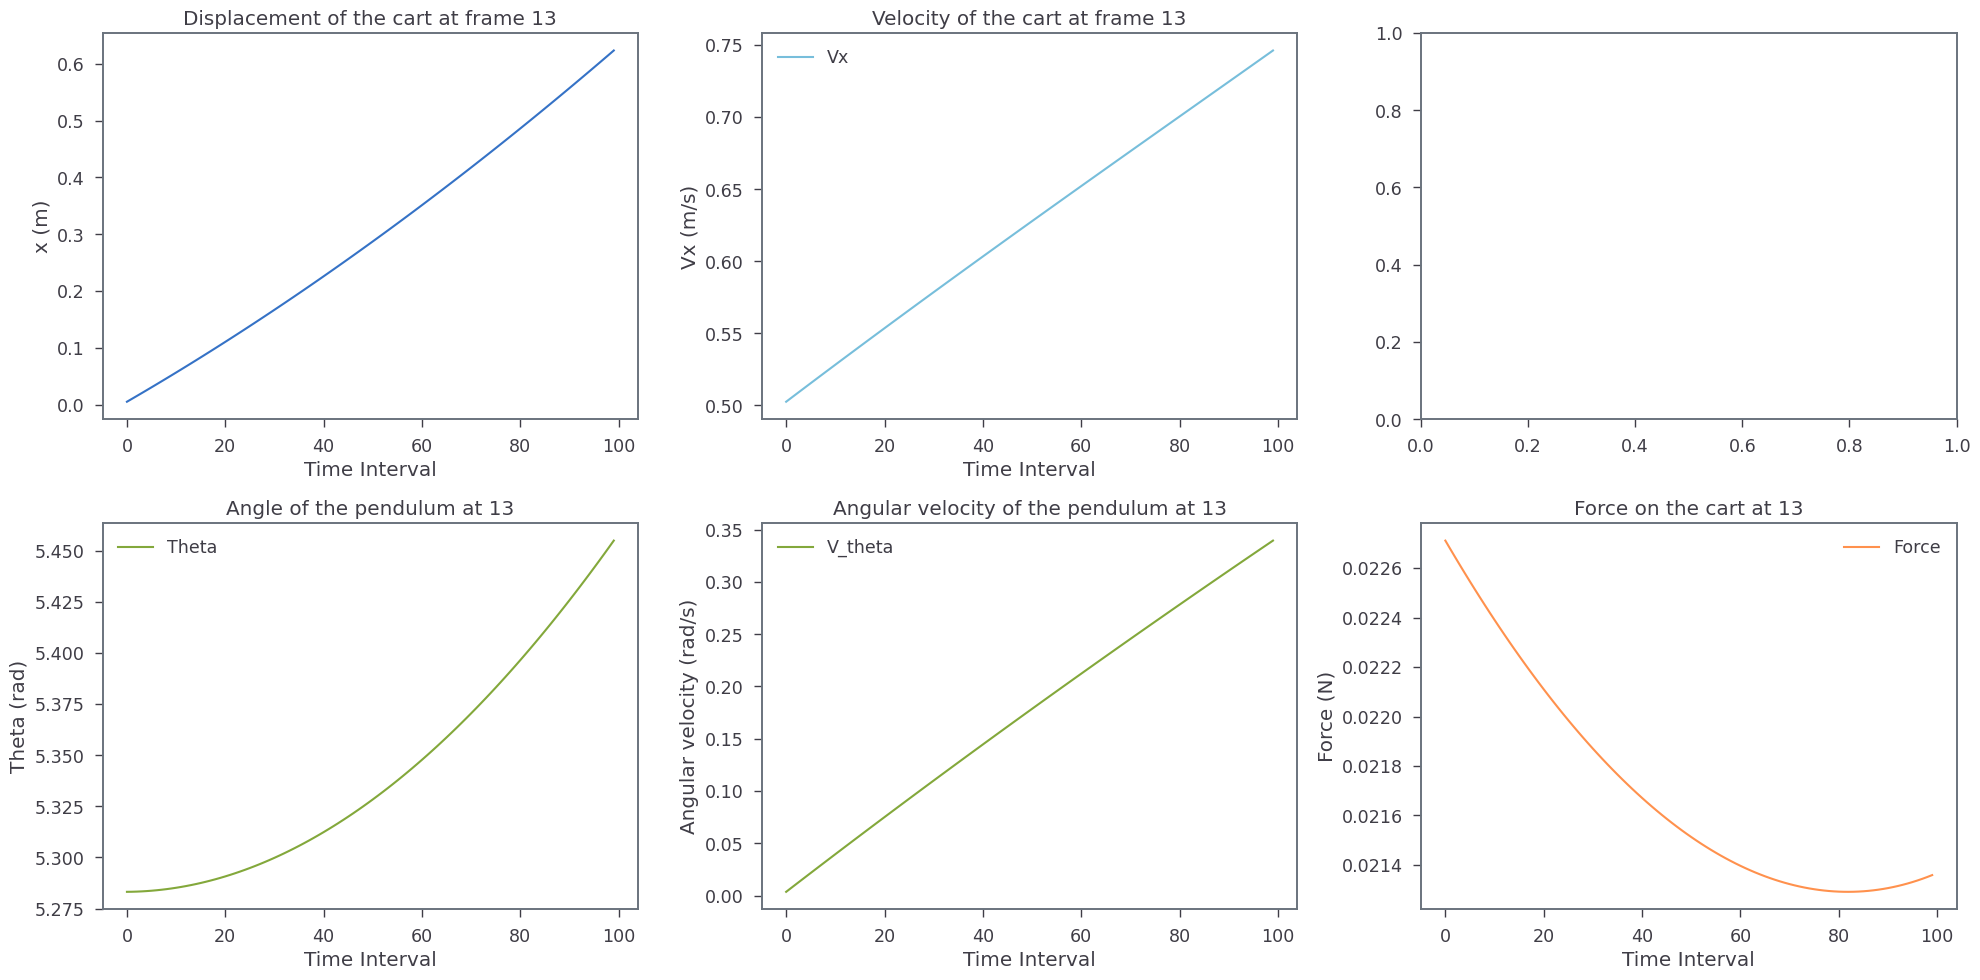

Angle: 302.7042305048303 5.2831855
Angle: 302.706306882338 5.2832217
Angle: 302.7104596373534 5.283294
Angle: 302.71668876987644 5.283403
Angle: 302.7249942799072 5.283548
Angle: 302.7353488466889 5.2837286
Angle: 302.74777979097837 5.2839456
Angle: 302.76225979201877 5.2841983
Angle: 302.7787888498102 5.284487
Angle: 302.7973942851093 5.2848115
Angle: 302.81802145640273 5.2851715
Angle: 302.84072500520386 5.2855678
Angle: 302.86545028999933 5.2859993
Angle: 302.8922246315458 5.2864666
Angle: 302.92104802984323 5.2869697
Angle: 302.951893164135 5.287508
Angle: 302.9847873551778 5.288082
Angle: 303.0197032822149 5.2886915
Angle: 303.05664094524633 5.289336
Angle: 303.09562766502876 5.2900167
Angle: 303.1366088000488 5.290732
Angle: 303.17961167106324 5.2914824
Angle: 303.22463627807196 5.2922683
Angle: 303.271682621075 5.2930894
Angle: 303.3207233793157 5.2939453
Angle: 303.3717858735507 5.2948365
Angle: 303.4248427830234 5.2957625
Angle: 303.4798941077337 5.2967234
Angle: 303.536967168

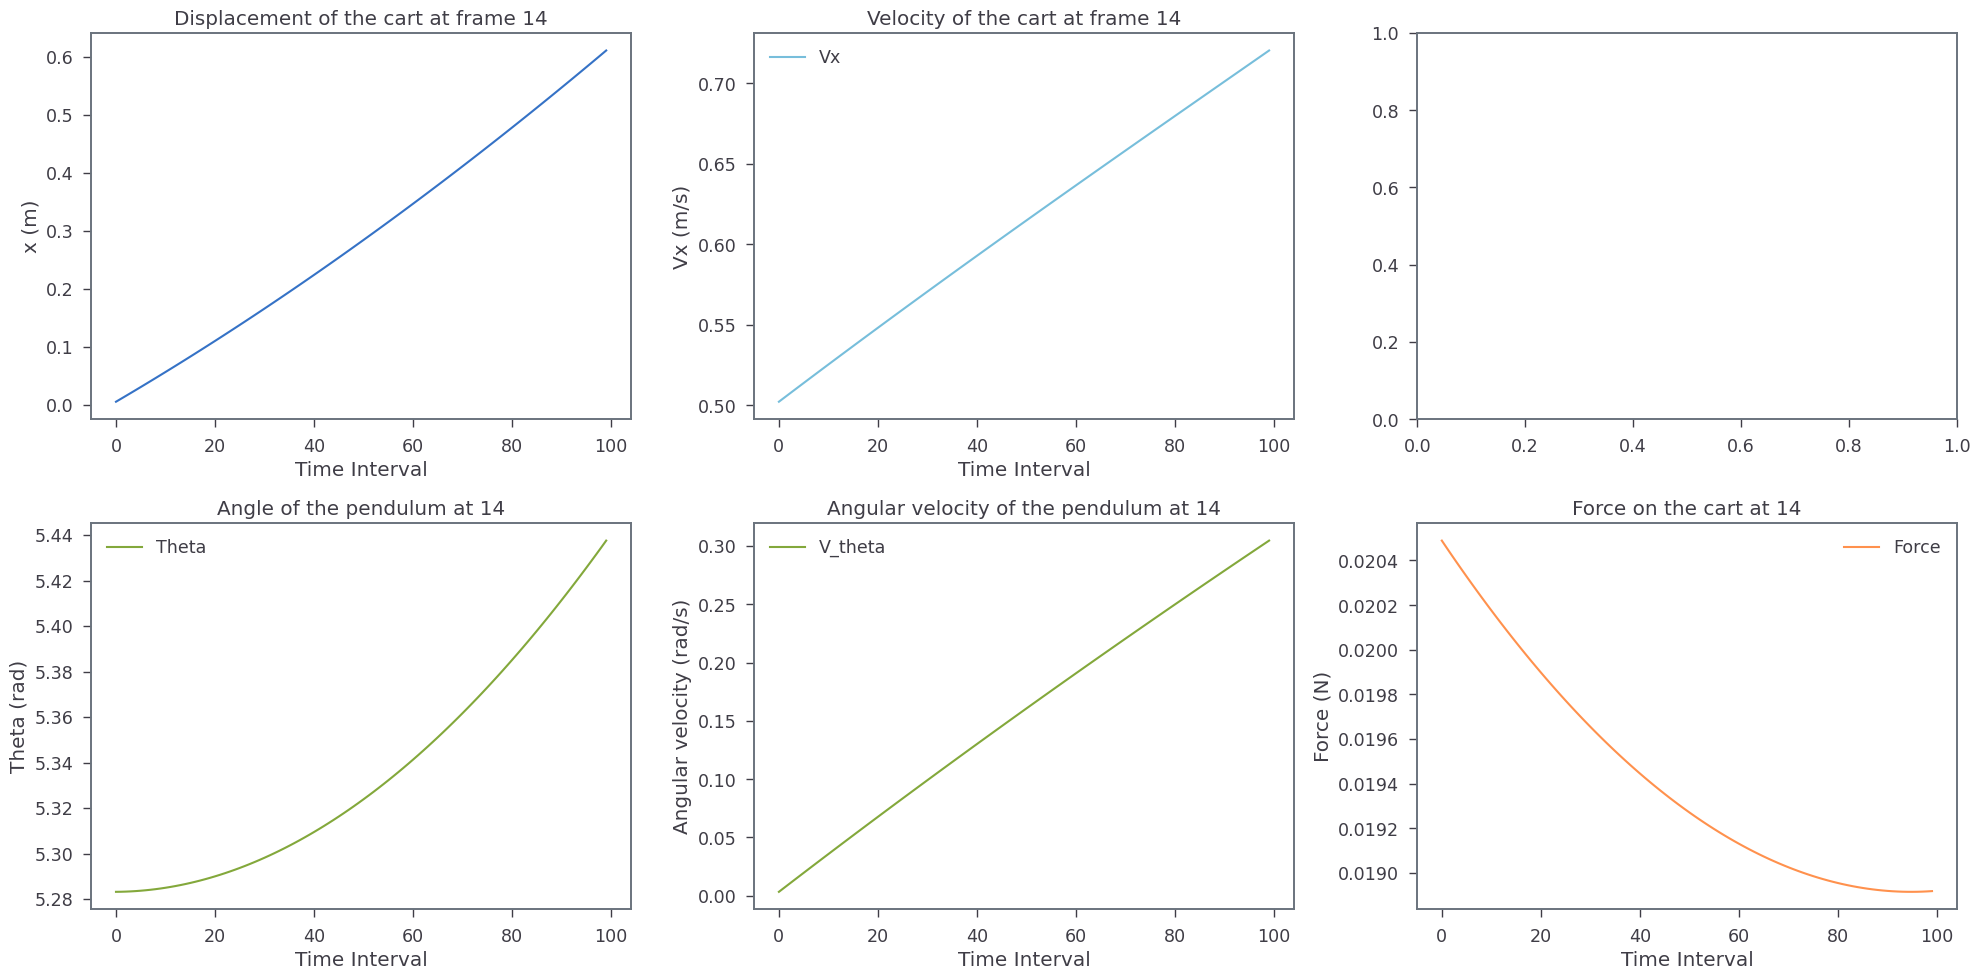

Angle: 302.7042305048303 5.2831855
Angle: 302.70611563704125 5.2832184
Angle: 302.70985858070645 5.2832837
Angle: 302.71545933582587 5.2833815
Angle: 302.72294522315616 5.283512
Angle: 302.7322889219408 5.283675
Angle: 302.74349043217956 5.2838707
Angle: 302.75654975387266 5.2840986
Angle: 302.7714668870199 5.284359
Angle: 302.7882418316215 5.2846518
Angle: 302.8068472669206 5.2849765
Angle: 302.827310513674 5.2853336
Angle: 302.8496042511249 5.2857227
Angle: 302.87375580003004 5.2861443
Angle: 302.8997378396328 5.2865977
Angle: 302.9275503699331 5.287083
Angle: 302.9571933909309 5.2876005
Angle: 302.98866690262633 5.28815
Angle: 303.0219709050193 5.288731
Angle: 303.0570780773532 5.289344
Angle: 303.09401574038463 5.2899885
Angle: 303.13278389411363 5.290665
Angle: 303.1733552177835 5.2913733
Angle: 303.21572971139426 5.292113
Angle: 303.25993469570255 5.2928843
Angle: 303.3059155291951 5.293687
Angle: 303.3537268533852 5.2945213
Angle: 303.4033413475162 5.2953873
Angle: 303.454731690

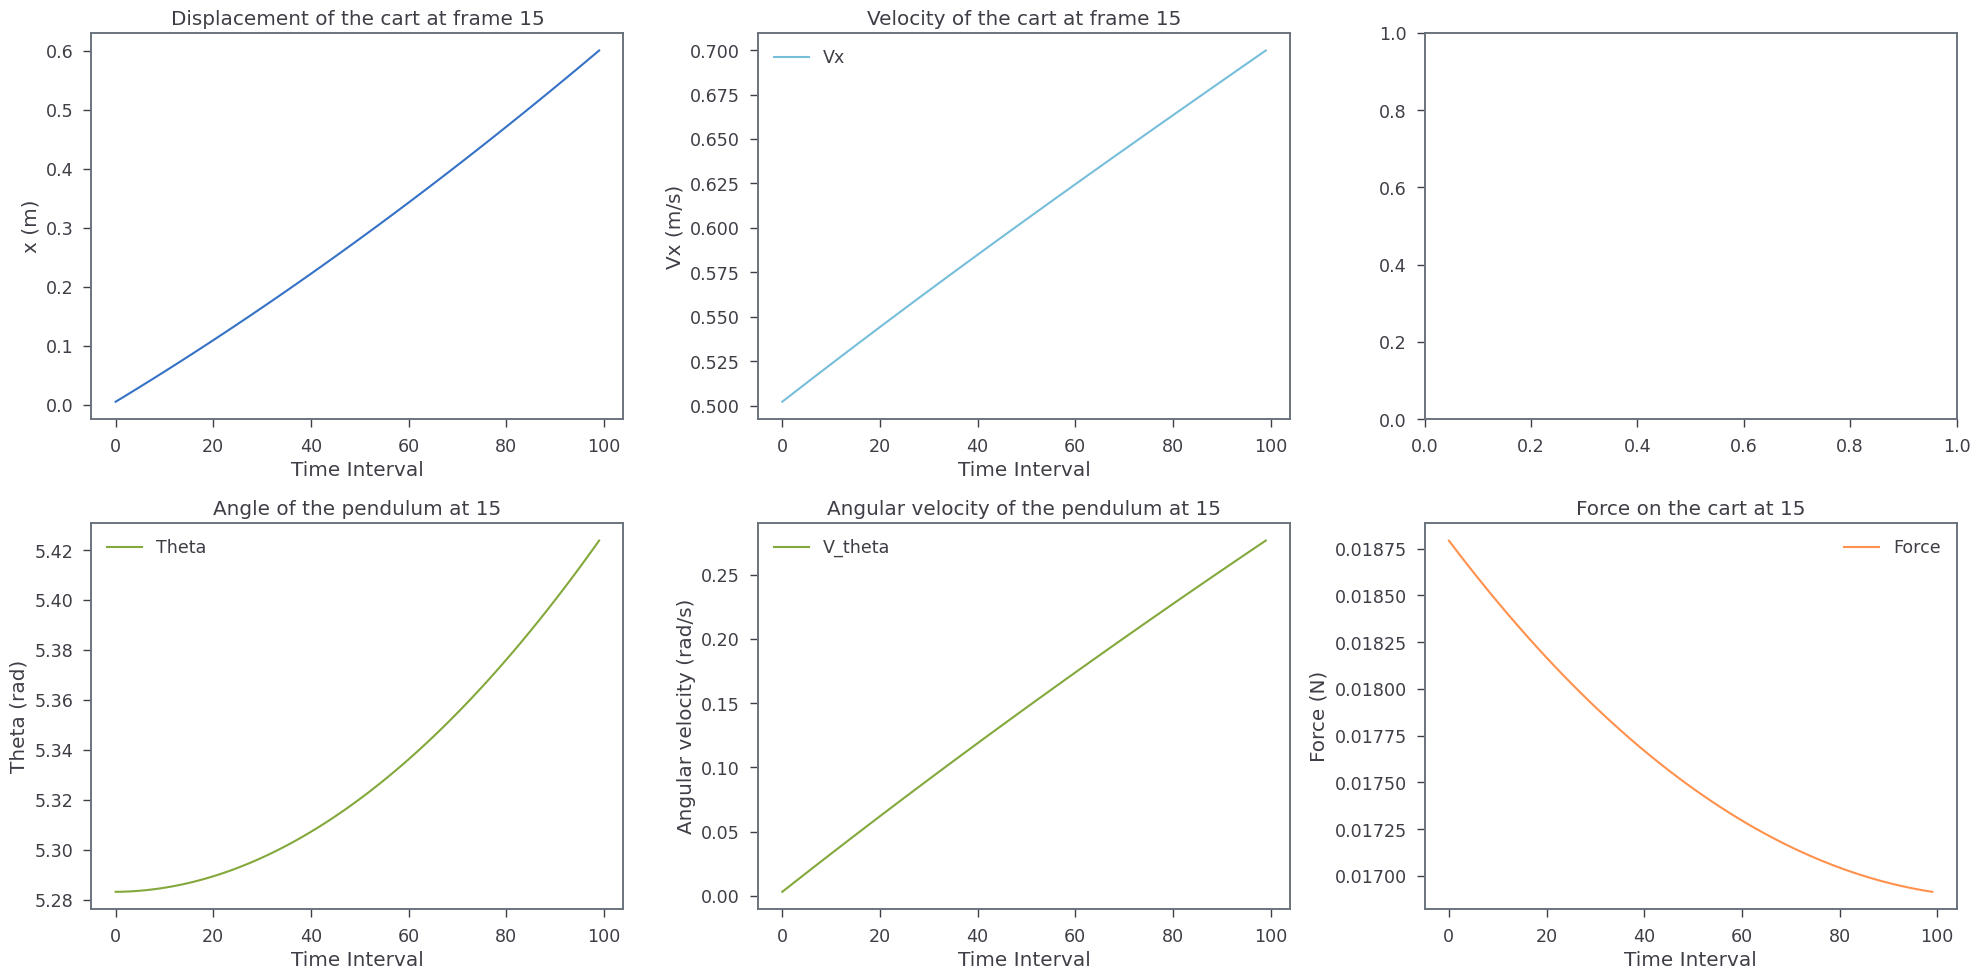

Angle: 302.7042305048303 5.2831855
Angle: 302.7059517125012 5.2832155
Angle: 302.70939412784287 5.2832756
Angle: 302.7145304300987 5.2833652
Angle: 302.7213879400254 5.283485
Angle: 302.729966657623 5.2836347
Angle: 302.74023926213465 5.283814
Angle: 302.75220575356053 5.284023
Angle: 302.76586613190057 5.284261
Angle: 302.7812477179114 5.2845297
Angle: 302.79829587007976 5.284827
Angle: 302.81703790916225 5.2851543
Angle: 302.83747383515896 5.285511
Angle: 302.8595763273131 5.285897
Angle: 302.88337270638146 5.286312
Angle: 302.90883565160726 5.2867565
Angle: 302.9359924837472 5.2872305
Angle: 302.964788561288 5.287733
Angle: 302.99527852574295 5.288265
Angle: 303.02743505635533 5.2888265
Angle: 303.06123083236855 5.2894163
Angle: 303.09669317453927 5.2900352
Angle: 303.1338220828675 5.2906833
Angle: 303.17261755735313 5.2913604
Angle: 303.2130522772396 5.292066
Angle: 303.2551262425269 5.2928004
Angle: 303.29883945321495 5.2935634
Angle: 303.34421923006056 5.2943554
Angle: 303.391210

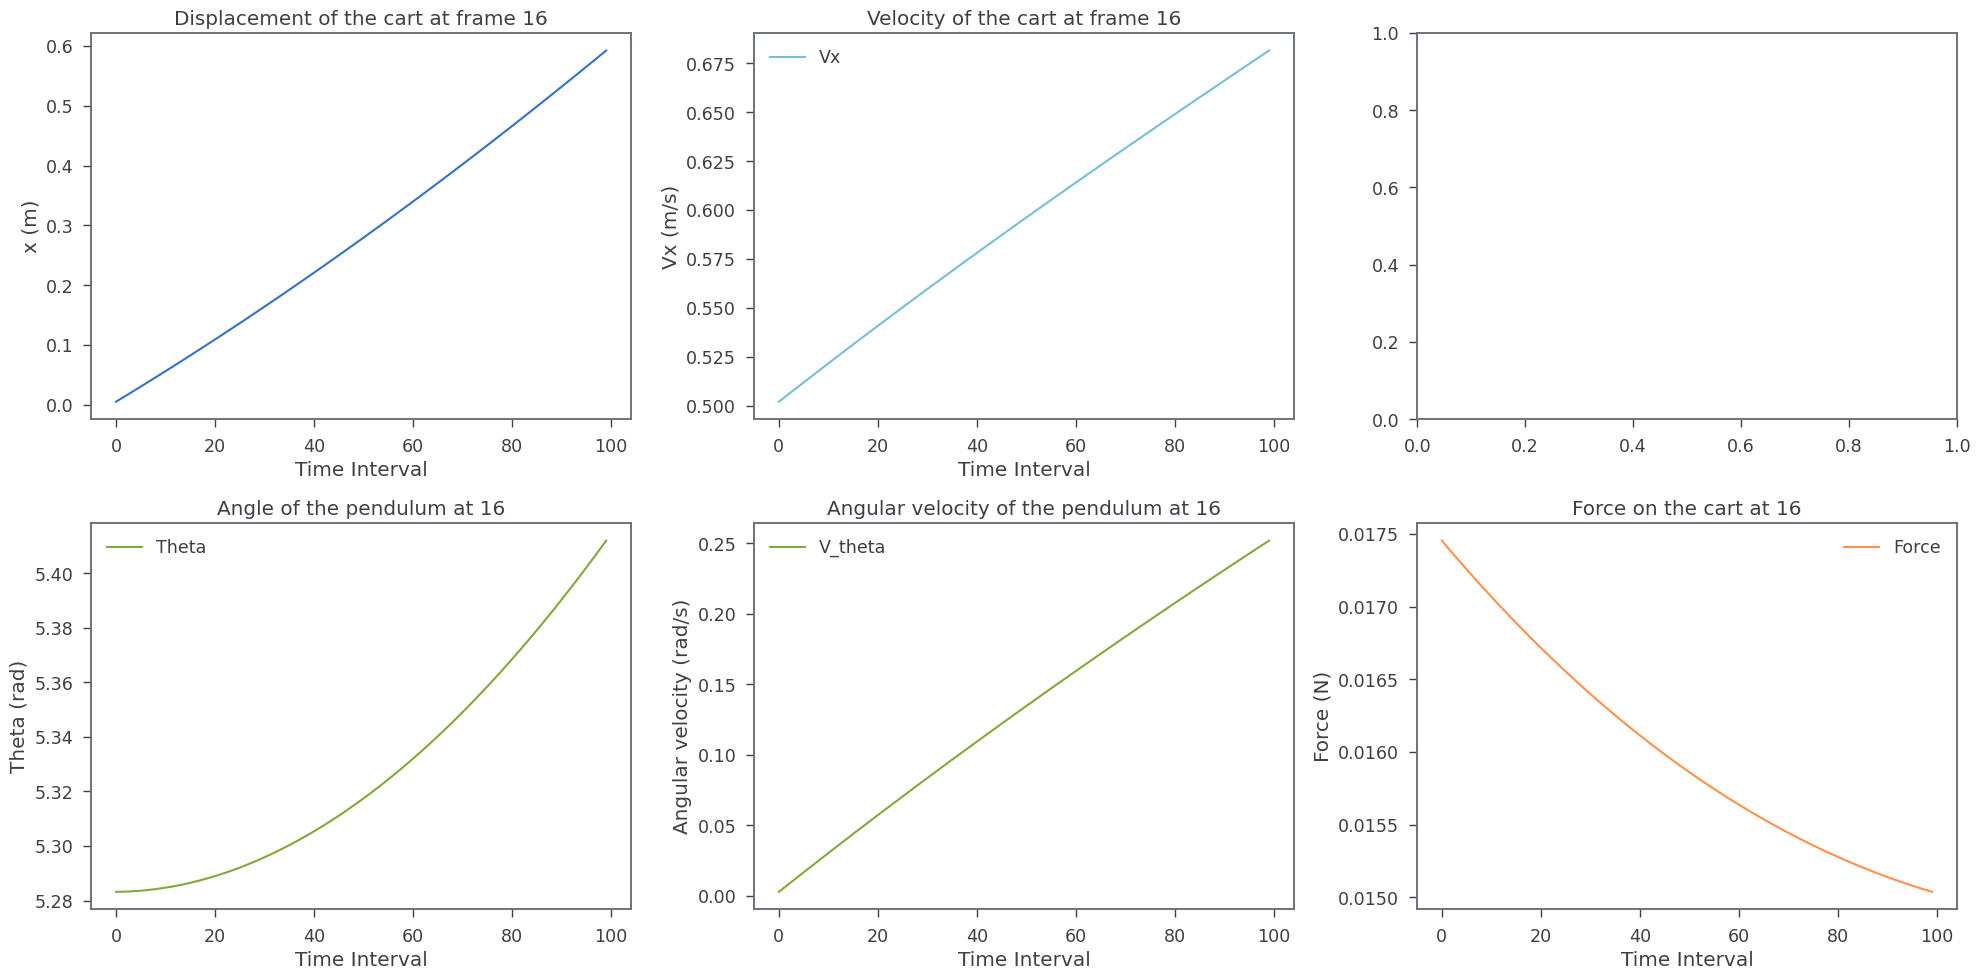

Angle: 302.7042305048303 5.2831855
Angle: 302.70584242947444 5.2832136
Angle: 302.7090116372494 5.283269
Angle: 302.7137927696684 5.2833524
Angle: 302.72015850597484 5.2834635
Angle: 302.7281088461687 5.283602
Angle: 302.73764379025005 5.2837687
Angle: 302.74873601746214 5.2839622
Angle: 302.7614128485617 5.2841835
Angle: 302.775646962792 5.284432
Angle: 302.79146568090977 5.284708
Angle: 302.8088416821583 5.2850113
Angle: 302.82774764578085 5.2853413
Angle: 302.84823821329087 5.285699
Angle: 302.870258743175 5.286083
Angle: 302.89386387694657 5.286495
Angle: 302.91897165233553 5.2869334
Angle: 302.9456367108553 5.287399
Angle: 302.9738317317491 5.287891
Angle: 303.003556715017 5.2884097
Angle: 303.03483898141565 5.2889557
Angle: 303.06762388943173 5.289528
Angle: 303.10193875982185 5.290127
Angle: 303.13778359258606 5.2907524
Angle: 303.1751310669677 5.2914042
Angle: 303.21398118296673 5.2920823
Angle: 303.25436126133985 5.292787
Angle: 303.29624398133035 5.293518
Angle: 303.339629342

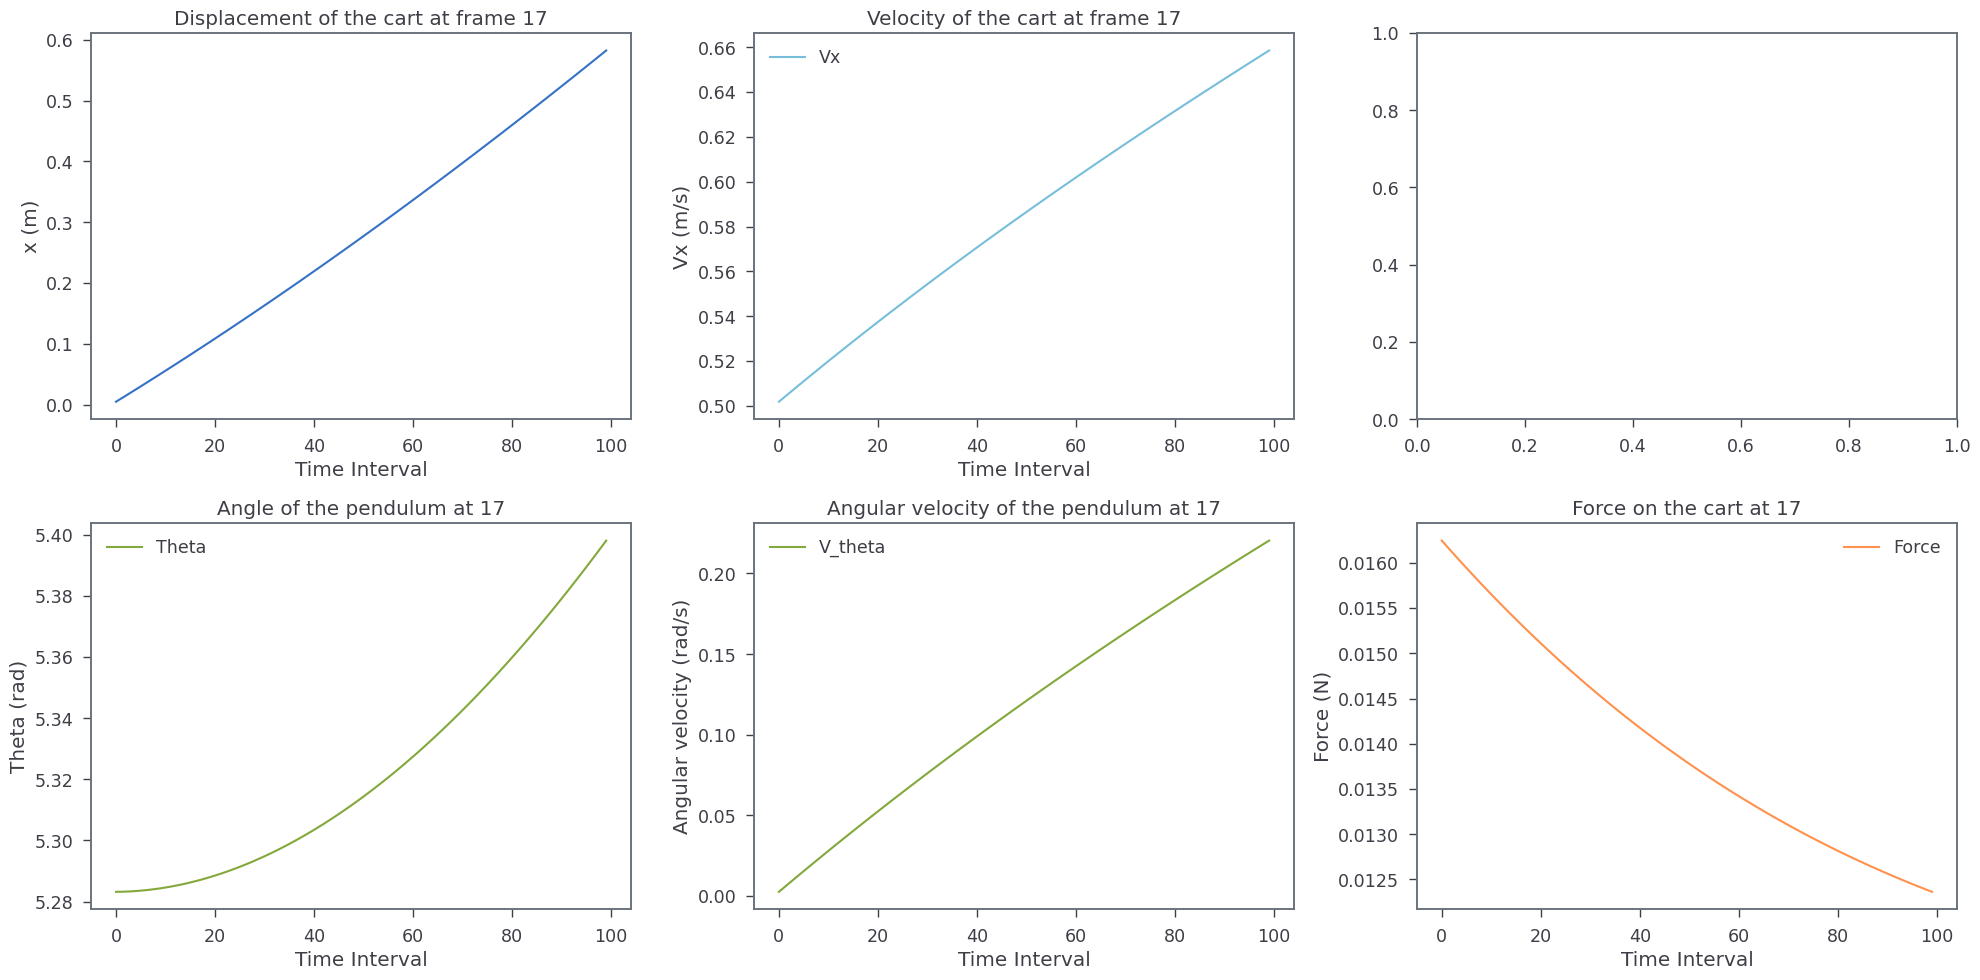

Angle: 302.7042305048303 5.2831855
Angle: 302.70570582569104 5.283211
Angle: 302.7086837881692 5.283263
Angle: 302.713137071508 5.283341
Angle: 302.71903835495095 5.283444
Angle: 302.72641495925456 5.2835727
Angle: 302.7352395636622 5.2837267
Angle: 302.7455394889306 5.2839065
Angle: 302.75726009354634 5.284111
Angle: 302.7704560190228 5.2843413
Angle: 302.7850726238466 5.2845964
Angle: 302.8011099080178 5.2848763
Angle: 302.81859519229306 5.2851815
Angle: 302.83747383515896 5.285511
Angle: 302.8578004781289 5.285866
Angle: 302.8795204796896 5.286245
Angle: 302.90263383984086 5.2866483
Angle: 302.92716787933955 5.2870765
Angle: 302.95309527742893 5.287529
Angle: 302.980416034109 5.288006
Angle: 303.00910282862304 5.2885065
Angle: 303.0391829817278 5.2890315
Angle: 303.0706291726665 5.2895803
Angle: 303.10346872219594 5.2901535
Angle: 303.13764698880266 5.29075
Angle: 303.1731912932434 5.2913704
Angle: 303.2101016355182 5.2920146
Angle: 303.24837801562694 5.2926826
Angle: 303.2879657920

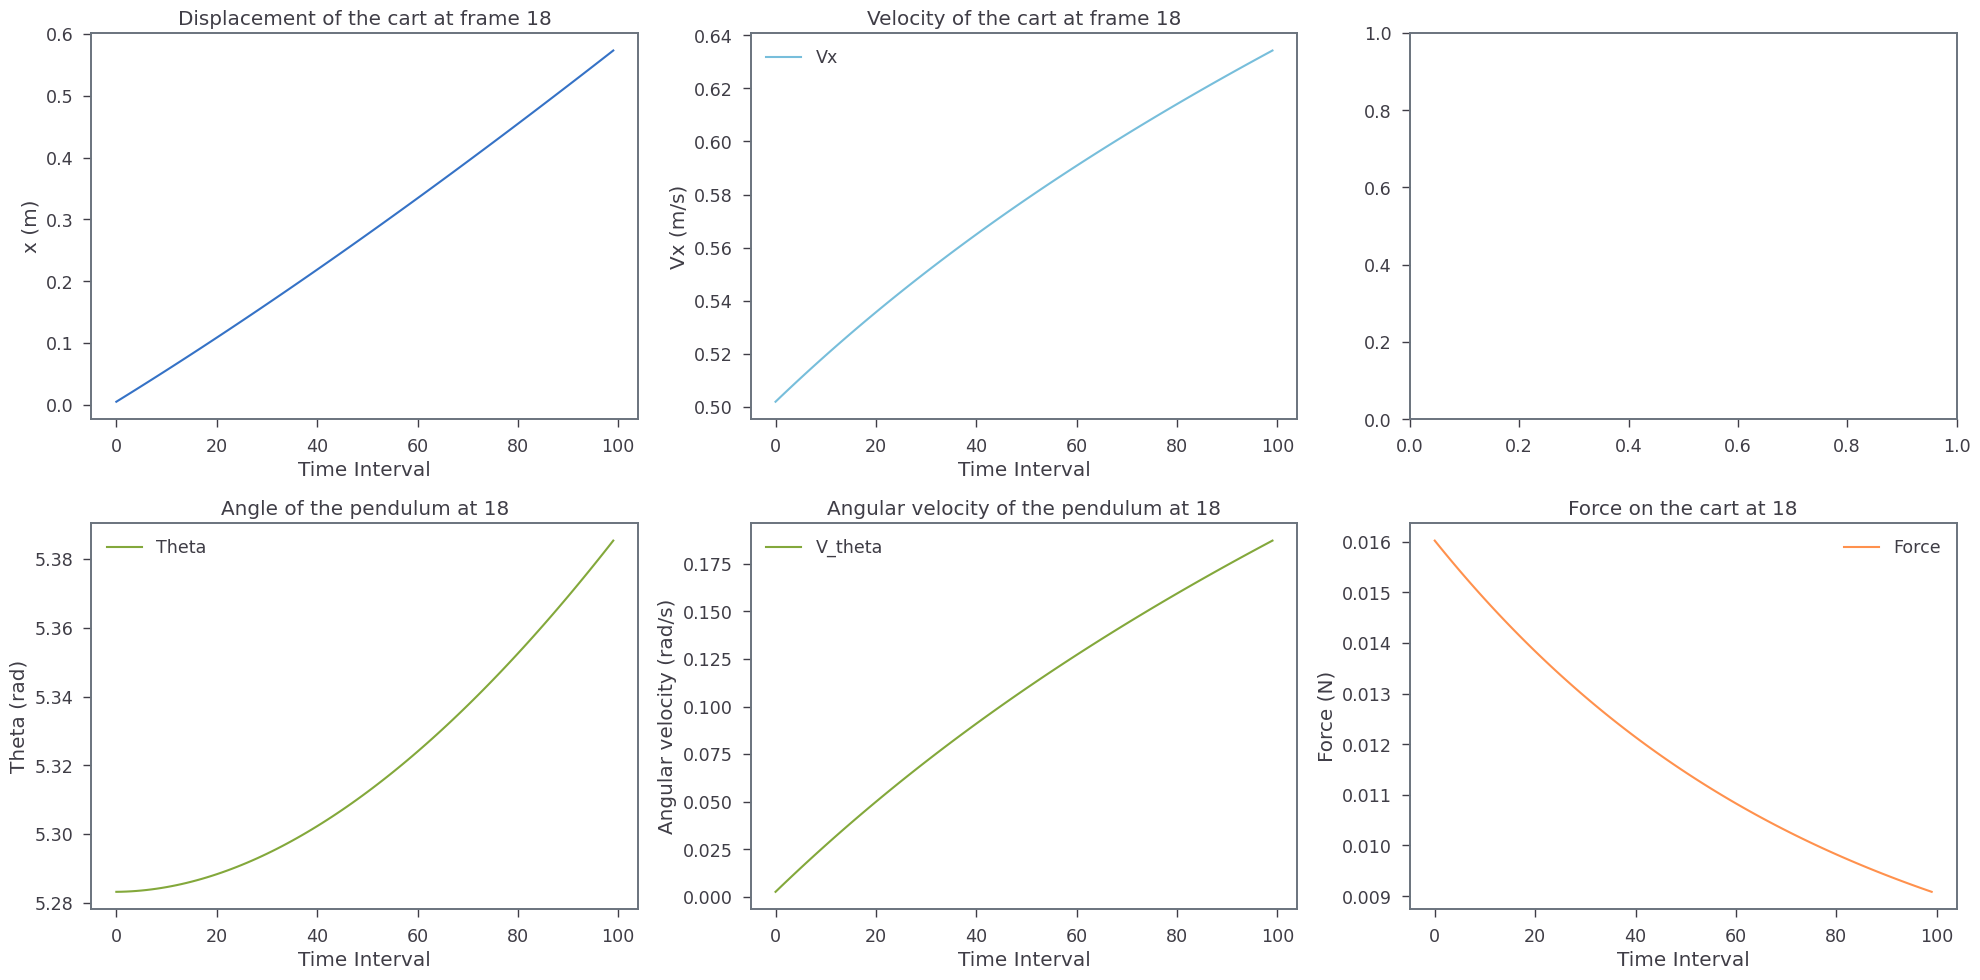

Angle: 302.7042305048303 5.2831855
Angle: 302.70570582569104 5.283211
Angle: 302.7086291466558 5.2832623
Angle: 302.71297314696795 5.283338
Angle: 302.71876514738415 5.283439
Angle: 302.72600514790435 5.2835655
Angle: 302.73463850701523 5.283716
Angle: 302.7446652247168 5.283891
Angle: 302.7560853010091 5.2840905
Angle: 302.7688714151353 5.2843137
Angle: 302.7830508878523 5.284561
Angle: 302.79856907764656 5.284832
Angle: 302.81545330527484 5.2851267
Angle: 302.83367624998044 5.2854447
Angle: 302.85321059100664 5.2857857
Angle: 302.8740836491102 5.28615
Angle: 302.8962681035344 5.286537
Angle: 302.9197366335226 5.286947
Angle: 302.9445165598314 5.2873793
Angle: 302.9705532409475 5.2878337
Angle: 302.99787399762755 5.2883105
Angle: 303.02647882987156 5.28881
Angle: 303.05631309616615 5.2893305
Angle: 303.0874041172681 5.289873
Angle: 303.1197245724206 5.290437
Angle: 303.15327446162365 5.291023
Angle: 303.18805378487735 5.29163
Angle: 303.2240625421817 5.2922583
Angle: 303.2612460920232

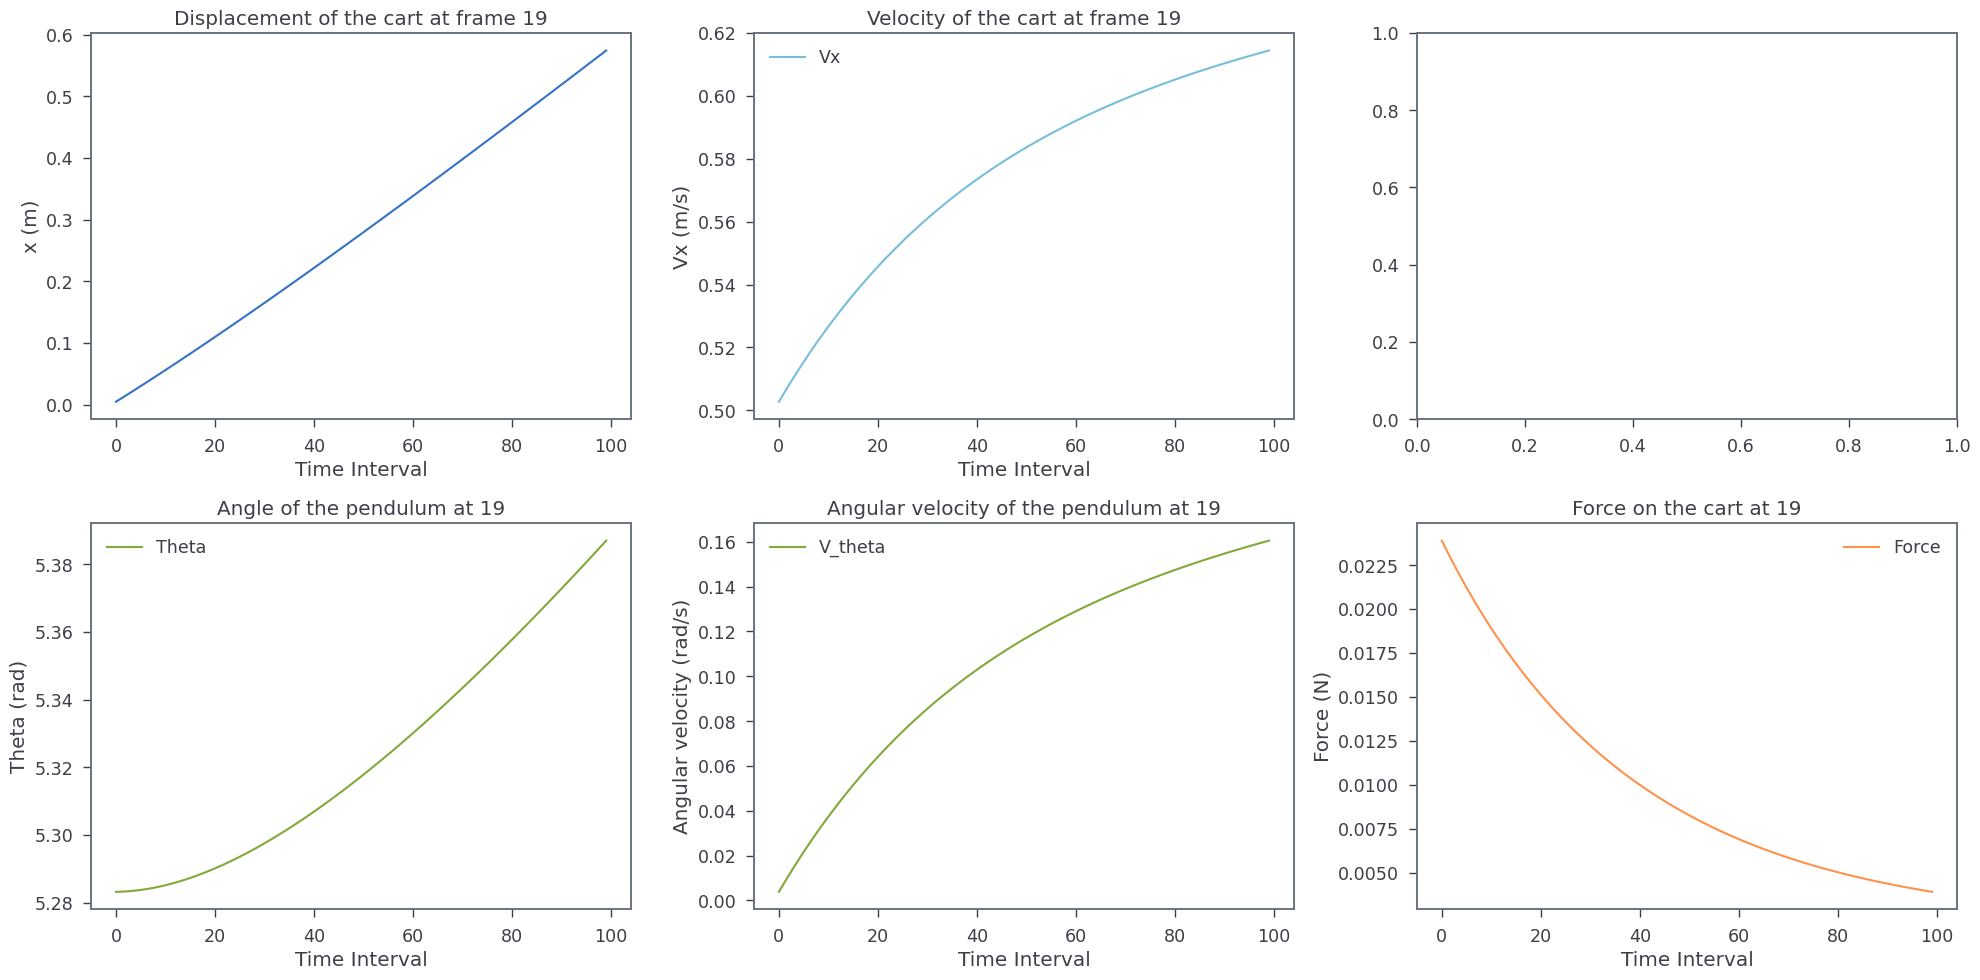

Angle: 302.7042305048303 5.2831855
Angle: 302.7064161653648 5.2832236
Angle: 302.7107328449202 5.283299
Angle: 302.71715322274 5.283411
Angle: 302.72559533655414 5.2835584
Angle: 302.73600454484927 5.28374
Angle: 302.7483808476253 5.283956
Angle: 302.762669603369 5.2842054
Angle: 302.7787888498102 5.284487
Angle: 302.7967112661923 5.2847996
Angle: 302.8164095317586 5.2851434
Angle: 302.83785632575245 5.2855177
Angle: 302.8609696859038 5.285921
Angle: 302.8857222914559 5.286353
Angle: 302.9121141424088 5.2868137
Angle: 302.94009059724925 5.287302
Angle: 302.96959701446366 5.287817
Angle: 303.00060607329556 5.288358
Angle: 303.0330904529881 5.288925
Angle: 303.06702283278474 5.2895174
Angle: 303.1023758919287 5.2901344
Angle: 303.1391223096634 5.290776
Angle: 303.1771801237187 5.29144
Angle: 303.216603975608 5.292128
Angle: 303.25728458230464 5.292838
Angle: 303.29924926456516 5.2935705
Angle: 303.34247070163303 5.294325
Angle: 303.38689425199476 5.2951
Angle: 303.4324925948938 5.295896


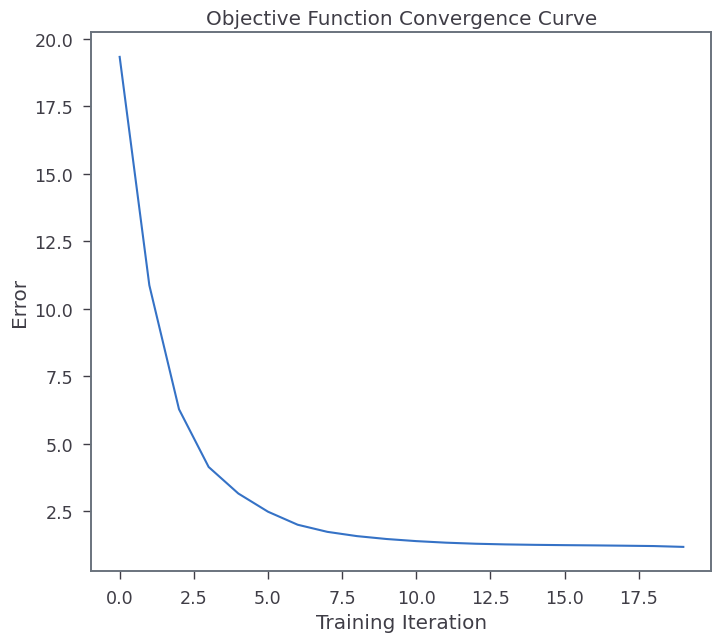

Generating Animation


IntProgress(value=0, max=101)

(100, 4) (100, 1)


<ipython-input-6-aa67e86d02ef>:142: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pend_fig.set_data(pendulum_x, pendulum_y)
<ipython-input-6-aa67e86d02ef>:143: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cart_fig.set_data(cart_x,0)
<ipython-input-6-aa67e86d02ef>:146: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  force_fig.set_data(cart_x+force_1 -0.5,0)


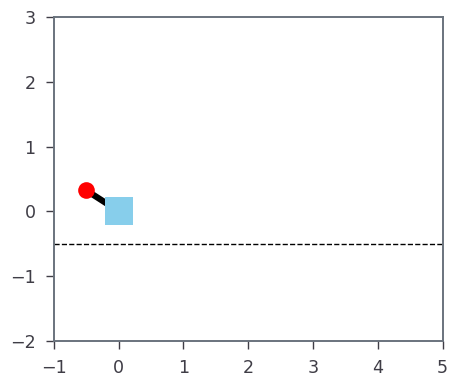

In [7]:
T = 100  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(20)  # training with number of epochs (gradient descent steps)
